In [1]:
import glob
import os
import sys

import matplotlib
import matplotlib.pyplot as plt
import polars as pl
import scikit_posthocs as sp
import seaborn as sns
from scipy.stats import levene, probplot

sys.path.append("../src")
from plots import (
    SYNTHWAVE_CATEGORICAL_PALETTE,
    SYNTHWAVE_PALETTE,
    SYNTHWAVE_SINGLE_HUE_PALETTE,
    bolden_ax,
    extend_palette,
    initiate_matplotlib_settings,
    lighten_color,
)

initiate_matplotlib_settings(
    font_path="/home/mball/Library/fonts/Lato",
    style_path="../reports/figure_styles.mplstyle",
)
"""
initiate_matplotlib_settings(
    font_path="/users/mattball/Library/Fonts",
    style_path="../reports/figure_styles.mplstyle",
    font_name="Lato",
)
"""

'\ninitiate_matplotlib_settings(\n    font_path="/users/mattball/Library/Fonts",\n    style_path="../reports/figure_styles.mplstyle",\n    font_name="Lato",\n)\n'

Here, just uncomment the solvent classification that you want, then run all.


In [ ]:
### CHANGE THIS BETWEEN COARSE AND FINE

# SOLVENT_CLASSIFICATION, use_coarse_hparams = "fine", True
SOLVENT_CLASSIFICATION, use_coarse_hparams = "coarse", True

os.makedirs(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies",
    exist_ok=True,
)
os.makedirs(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/metrics", exist_ok=True
)
DATA_DIR = f"../data/parsed_jacs_data/{SOLVENT_CLASSIFICATION}_solvs"

First, in the case where predictions of classes are dependent on one another, i.e. we predict the most probable condition set, and then take the predictions of the solvent and reagent from that:


In [3]:
def get_results_from_all_experiments(
    results_folder: str,
    method_col: str,
    filename: str = "top_k_accuracies.csv",
    replace_reagent_type: bool = True,
    solvent_classification: str = SOLVENT_CLASSIFICATION,
) -> pl.DataFrame:
    """Gets the top-k accuracies for all repetitions and folds for a given results folder.

    Expects the results folder to have the following structure:
    results_folder
    ├── split_i
    │   ├── fold_j
    │   │   ├── top_k_accuracies.csv

    :param results_folder: The path to the results folder.
    :type results_folder: str
    :param method_col: The name of the method, used to add a method column to the final DataFrame.
    :type method_col: str
    :param filename: The name of the file containing the desired metrics.
    :type filename: str
    :param replace_reagent_type: Whether to replace the reagent type with a more readable name.
    :type replace_reagent_type: bool
    :param solvent_classification: The solvent classification used, when replacing reagent type (e.g. {<solvent_classification>_solvent : Solvent}).
    :type solvent_classification: str
    :return: Results DataFrame.
    :rtype: pl.DataFrame
    """
    combined_results_df = None
    split_results = glob.glob(f"{results_folder}/*")
    split_results.sort()
    for split_result in split_results:
        split = os.path.basename(split_result).split("_")[-1]
        fold_results = glob.glob(f"{split_result}/*")
        fold_results.sort()
        for fold_result in fold_results:
            fold = os.path.basename(fold_result).split("_")[-1]
            try:
                individual_experiment_results_df = pl.read_csv(
                    os.path.join(fold_result, filename)
                )
                individual_experiment_results_df = (
                    individual_experiment_results_df.with_columns(
                        [
                            pl.Series(
                                "split",
                                [split]
                                * len(individual_experiment_results_df),
                            ),
                            pl.Series(
                                "fold",
                                [fold] * len(individual_experiment_results_df),
                            ),
                        ]
                    )
                )

                if combined_results_df is None:
                    combined_results_df = individual_experiment_results_df
                else:
                    combined_results_df = pl.concat(
                        [combined_results_df, individual_experiment_results_df]
                    )
            except Exception as e:
                print(f"Error reading {fold_result}: {e}")
                continue

    if replace_reagent_type:
        combined_results_df = combined_results_df.with_columns(
            [
                pl.col("reagent_type").replace(
                    {
                        f"{solvent_classification}_solvent": "Solvent",
                        "base": "Base",
                        "overall": "Overall",
                    }
                )
            ]
        )

    combined_results_df = combined_results_df.with_columns(
        [pl.Series("method", [method_col] * len(combined_results_df))]
    )

    return combined_results_df

In [4]:
def get_all_method_results(
    models: list,
    methods: list,
    filename: str,
    results_dir: str = None,
    replace_reagent_type: bool = True,
    solvent_classification: str = SOLVENT_CLASSIFICATION,
    use_coarse_hparams: bool = True,
) -> pl.DataFrame:
    """Gets all the results for a list of models, a results directory, and a filename.

    :param models: A list of the different models to collect results for, where the results for the model are in the {results_dir}/{model}_results directory.
    :type models: list
    :param methods: A corresponding list of the method names for each model (used to add a method column to the final DataFrame).
    :type methods: list
    :param filename: The name of the file containing the desired metrics.
    :type filename: str
    :param results_dir: The results directory, where the individual model results directories can be found, defaults to None
    :type results_dir: str, optional
    :param replace_reagent_type: If true, replaces the reagent names to be more readable, defaults to True
    :type replace_reagent_type: bool, optional
    :param solvent_classification: Solvent classification to find results for, defaults to SOLVENT_CLASSIFICATION
    :type solvent_classification: str, optional
    :param use_coarse_hparams: Whether coarse_hparams were used (changes the model results folder name), defaults to True
    :type use_coarse_hparams: bool, optional
    :return: DataFrame containing all results for the given models.
    :rtype: pl.DataFrame
    """
    all_results_df = None
    if results_dir is None:
        results_dir = f"{DATA_DIR}"
    for model, method in zip(
        models,
        methods,
    ):
        model_results_dir = f"{results_dir}/{model}_results"

        if (
            solvent_classification == "fine"
            and use_coarse_hparams
            and model in ["cgr_rf", "cgr_gbm", "cgr_mtnn", "cgr_dmpnn"]
        ):
            model_results_dir += "_coarse_hparams"

        results_df = get_results_from_all_experiments(
            results_folder=model_results_dir,
            method_col=method,
            filename=filename,
            replace_reagent_type=replace_reagent_type,
            solvent_classification=solvent_classification,
        )

        if all_results_df is None:
            all_results_df = results_df
        else:
            all_results_df = pl.concat(
                [all_results_df, results_df.select(all_results_df.columns)]
            )

    return all_results_df

We will compare traditional ML methods (Random Forest and Gradient Boosting Machines) with simple baselines (popularity and similarity)


In [5]:
ml_models = ["cgr_rf", "cgr_gbm", "cgr_mtnn", "cgr_dmpnn", "morgan_mtnn"]
ml_methods = [
    "CGR RF",
    "CGR GBM",
    "CGR MTNN",
    "CGR D-MPNN",
    "Morgan MTNN",
]

baseline_models = ["baseline_pop", "baseline_knn"]
baseline_methods = ["Pop. Baseline", "Sim. Baseline"]

In [6]:
top_k_accuracies = get_all_method_results(
    models=ml_models + baseline_models,
    methods=ml_methods + baseline_methods,
    filename="top_k_accuracies.csv",
)

independent_top_k_accuracies = get_all_method_results(
    models=ml_models + baseline_models,
    methods=ml_methods + baseline_methods,
    filename="independent_top_k_accuracies.csv",
)

In [7]:
independent_metrics = get_all_method_results(
    models=ml_models + baseline_models,
    methods=ml_methods + baseline_methods,
    filename="independent_metrics.csv",
    replace_reagent_type=False,
)

In [8]:
import matplotlib.figure


def plot_model_performance(
    vis_df: pl.DataFrame,
    hue_order: list,
    reagent_types: list = ["Base", "Solvent", "Overall"],
    figsize: tuple = (8, 6),
    palette: list = SYNTHWAVE_CATEGORICAL_PALETTE,
    despine: bool = True,
    share_y: bool = True,
    fill: bool = False,
):
    fig, axs = plt.subplots(
        ncols=len(reagent_types), figsize=figsize, sharey=share_y
    )

    for reagent_type, ax in zip(reagent_types, axs):
        if despine:
            sns.despine(ax=ax)

        sns.boxplot(
            data=vis_df.filter(pl.col("reagent_type") == reagent_type),
            x="top_k",
            y="accuracy",
            hue="method",
            hue_order=hue_order,
            palette=palette,
            saturation=1,
            dodge=True,
            ax=ax,
            width=0.7,
            gap=0.2,
            fliersize=2,
        )

        set_boxplot_fill_styles(fill, ax)

        if ax == axs[-1]:
            ax.legend(
                title="Method", loc="upper center", bbox_to_anchor=(0.25, 1.04)
            )
            ax.get_legend().set_frame_on(False)
        else:
            ax.get_legend().remove()

        ax.set_xlabel("Top K")
        ax.set_ylabel("Accuracy @ K")
        ax.set_title(reagent_type.title(), ha="left", x=0)

        ax.set_xticks([0.5, 1.5, 2.5], minor=True)
        ax.grid(
            which="minor",
            axis="x",
            linestyle="-",
            alpha=0.6,
            zorder=0,
            linewidth=0.5,
        )
        ax.grid(
            which="major",
            axis="y",
            linestyle="-",
            alpha=0.6,
            zorder=0,
            linewidth=0.5,
        )

        bolden_ax(
            ax,
            despine=despine,
            spine_linewidth=1.5,
            tick_linewidth=1.5,
            label_fontsize=None,
            title_fontsize=None,
            legend_fontsize=None,
        )

        ax.set_ylim(0, 1)
        ax.tick_params(axis="x", which="minor", bottom=False, length=3)
        ax.tick_params(axis="x", which="major", direction="out")

    return fig, axs


def set_boxplot_fill_styles(fill: bool, ax: matplotlib.axes.Axes) -> None:
    """Set the fill styles for the boxplots.

    If fill is false, colours the outline of the boxplot. If fill is true, fills the boxplot,
    darkening the edges.

    :param fill: Whether to fill the boxplots, or just colour the outline.
    :type fill: bool
    :param ax: The axis to set the fill styles on.
    :type ax: matplotlib.axes.Axes
    """
    box_patches = [
        patch
        for patch in ax.patches
        if type(patch) is matplotlib.patches.PathPatch
    ]
    if (
        len(box_patches) == 0
    ):  # in matplotlib older than 3.5, the boxes are stored in axs.artists
        box_patches = ax.artists

    num_patches = len(box_patches)
    lines_per_boxplot = len(ax.lines) // num_patches
    for i, patch in enumerate(box_patches):
        # Set the linecolor on the patch to the facecolor, and set the facecolor to None
        col = patch.get_facecolor()

        if not fill:
            patch.set_edgecolor(col)
            patch.set_facecolor("None")
        else:
            patch.set_edgecolor(lighten_color(col, 1.2))
            patch.set_linewidth(1)

        # Each box has associated Line2D objects (to make the whiskers, fliers, etc.)
        # Loop over them here, and use the same color as above
        for line in ax.lines[
            i * lines_per_boxplot : (i + 1) * lines_per_boxplot
        ]:
            if not fill:
                line.set_linewidth(1)
                line.set_mew(1)
                line.set_color(col)
                line.set_mfc("None")
                line.set_mec(col)
            else:
                line.set_linewidth(1)
                line.set_mew(1)
                line.set_color(lighten_color(col, 1.2))
                line.set_mfc("None")
                line.set_mec(lighten_color(col, 1.2))


def add_titles(
    fig: matplotlib.figure.Figure,
    title: str,
    subtitle: str,
    subtitle_y: float = 0.90,
) -> None:
    fig.suptitle(
        t=title,
        ha="left",
        x=0,
        y=1,
    )

    fig.text(
        x=0,
        y=subtitle_y,
        s=subtitle,
        fontdict={
            "ha": "left",
            "style": "italic",
            "weight": "regular",
        },
    )


def create_fig_legend(
    fig: matplotlib.figure.Figure,
    axs: matplotlib.axes.Axes,
    title: str = "Method",
    n_cols: int = 4,
    bbox_to_anchor: tuple = (0.7, 1.025),
    fill_legend: bool = True,
) -> None:
    handles, labels = axs[-1].get_legend_handles_labels()
    axs[-1].get_legend().remove()

    # Also fix the legend
    for legpatch in fig.legend(
        handles,
        labels,
        loc="upper center",
        bbox_to_anchor=bbox_to_anchor,
        ncol=n_cols,
        title=title,
    ).get_patches():
        col = legpatch.get_facecolor()
        if not fill_legend:
            legpatch.set_edgecolor(col)
            legpatch.set_facecolor("None")
        else:
            legpatch.set_edgecolor("None")
            legpatch.set_facecolor(col)

/tmp/ipykernel_1729705/3682100079.py:25: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


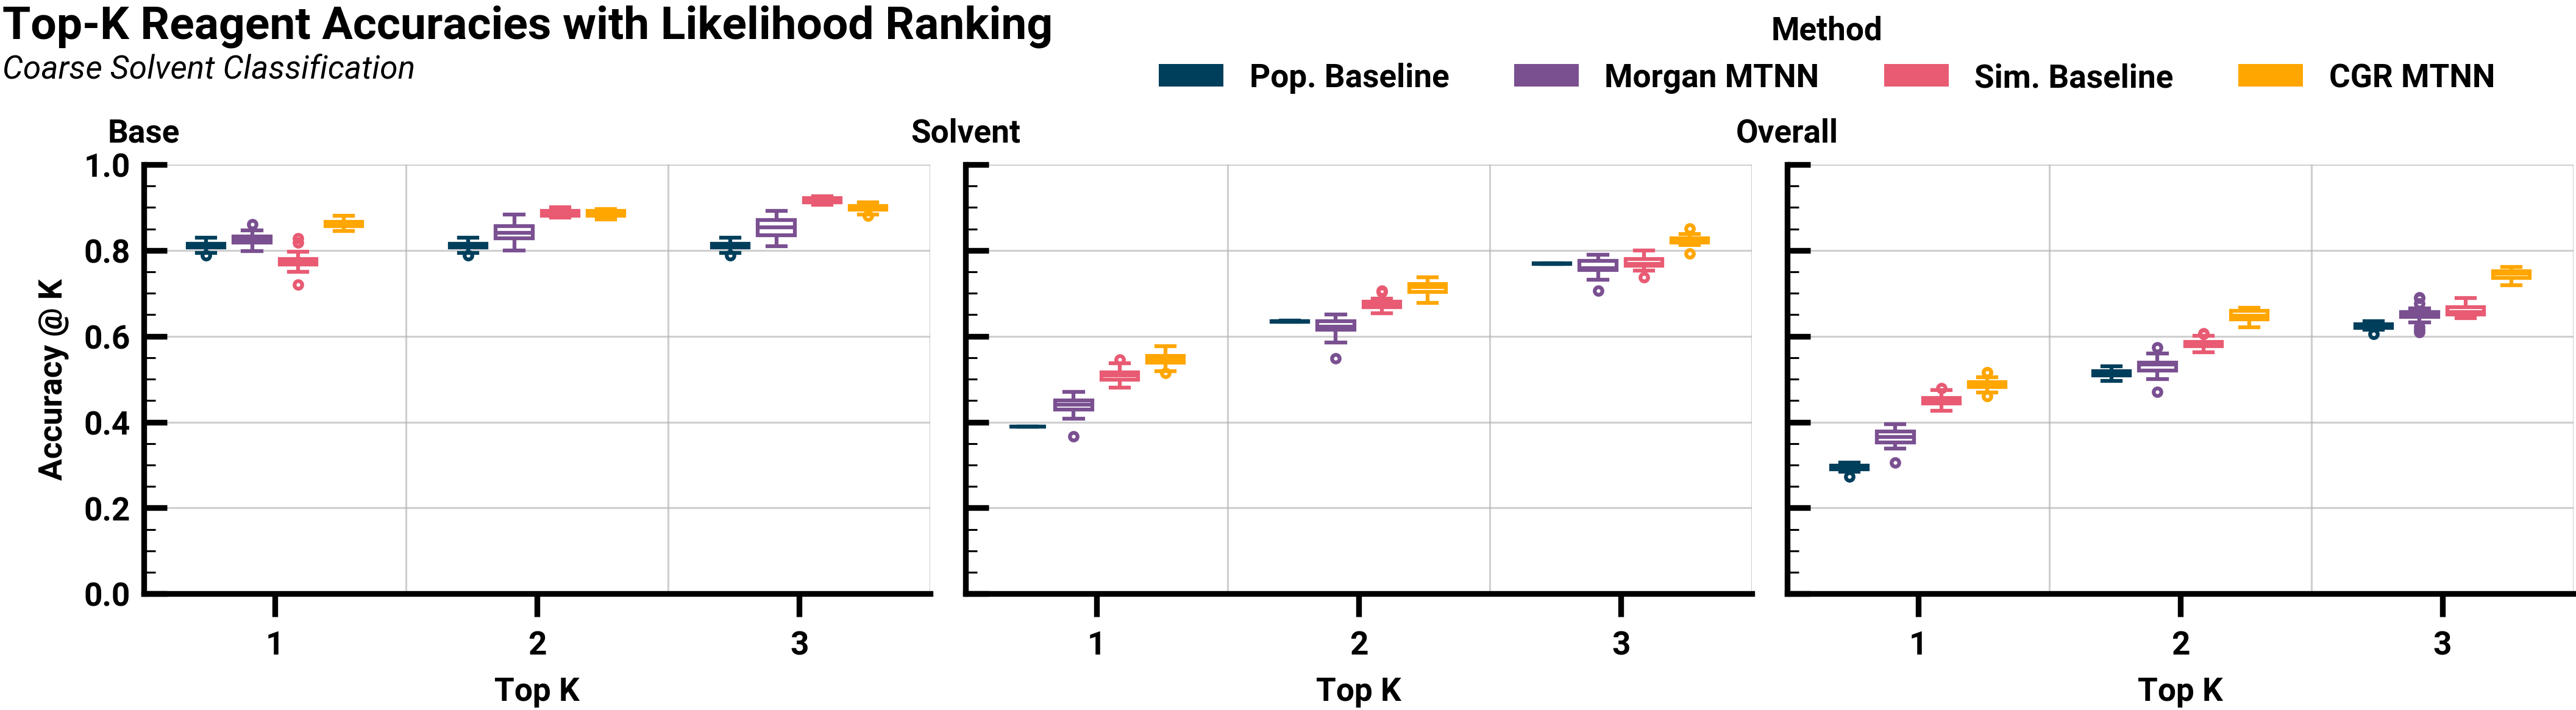

In [9]:
vis_df = top_k_accuracies.filter(pl.col("top_k") <= 3)

fill = False
fill_legend = True
n_plots = 3
palette = extend_palette(4, SYNTHWAVE_PALETTE)

fig, axs = plot_model_performance(
    vis_df,
    hue_order=["Pop. Baseline", "Morgan MTNN", "Sim. Baseline", "CGR MTNN"],
    figsize=(3.5 * n_plots - (n_plots - 1) * 0.5, 2.69),
    palette=palette,
    despine=True,
    fill=fill,
)

add_titles(
    fig=fig,
    title="Top-K Reagent Accuracies with Likelihood Ranking",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification",
)

create_fig_legend(fig, axs, n_cols=4, fill_legend=fill_legend)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies/top_k_accuracies_with_likelihood_ranking.svg",
    bbox_inches="tight",
)

/tmp/ipykernel_1729705/2163209936.py:21: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


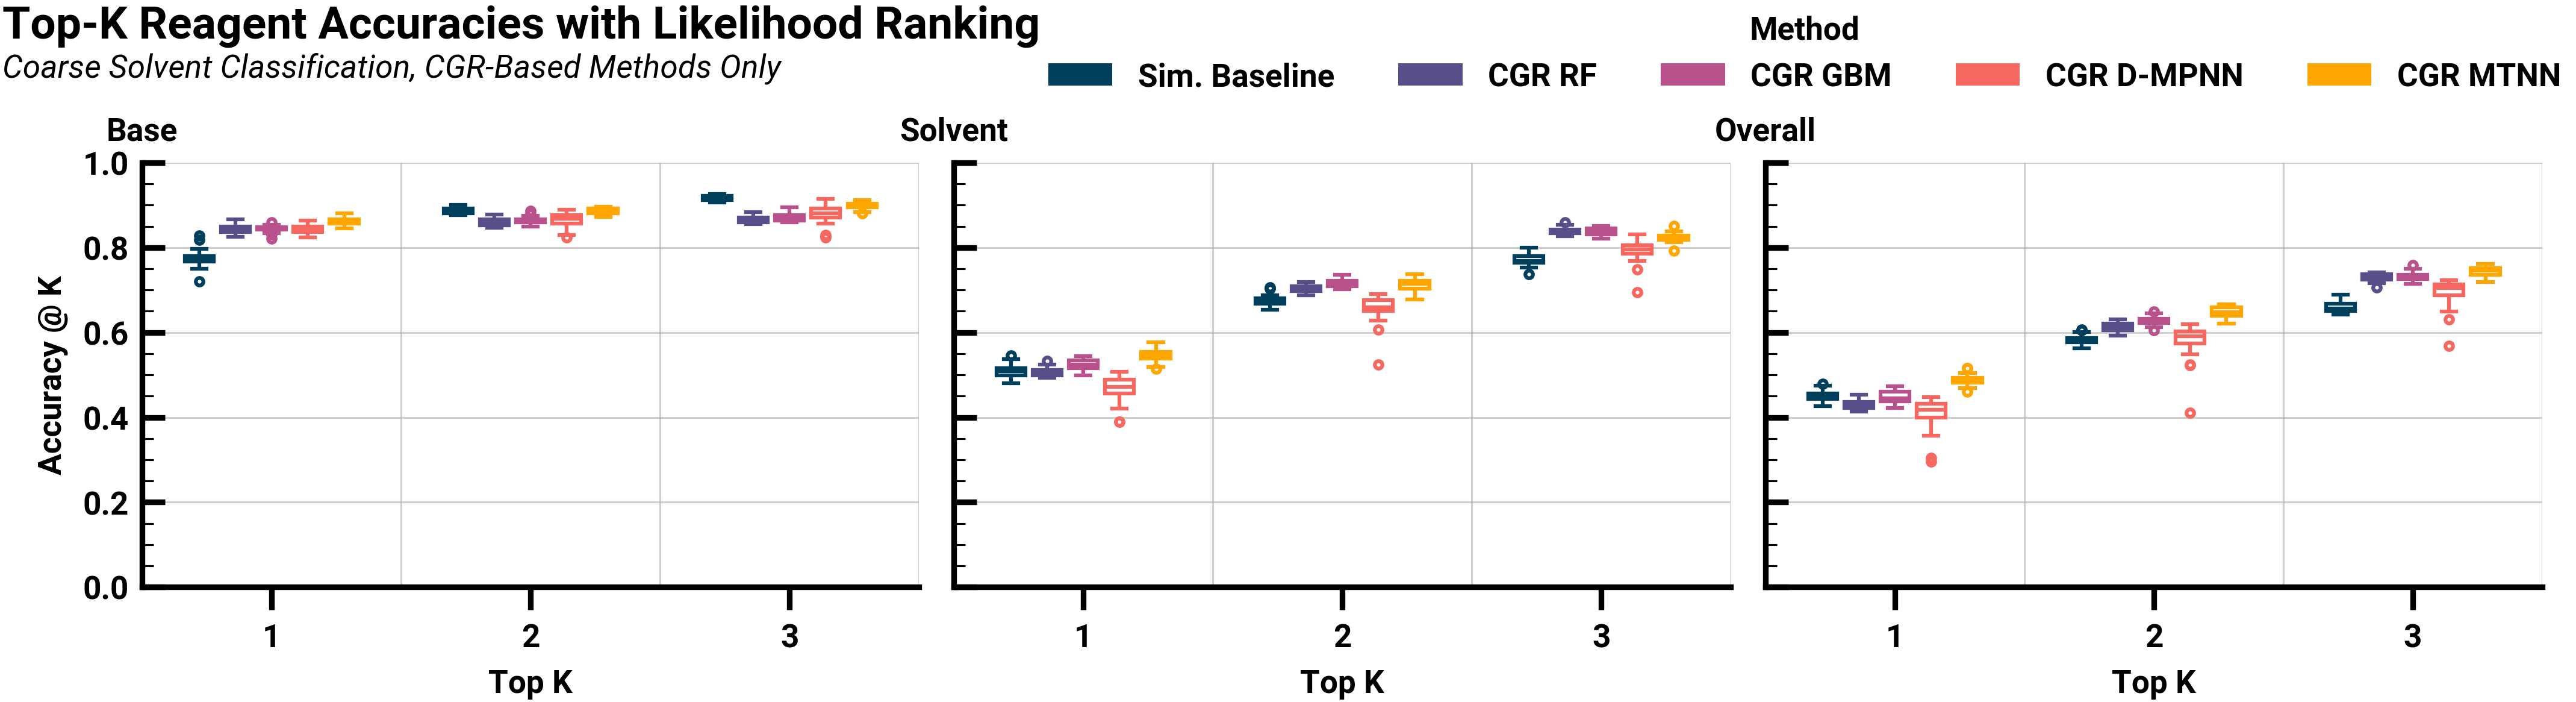

In [10]:
cgr_only_palette = extend_palette(5, SYNTHWAVE_PALETTE)
n_plots = 3

fig, axs = plot_model_performance(
    vis_df,
    hue_order=["Sim. Baseline", "CGR RF", "CGR GBM", "CGR D-MPNN", "CGR MTNN"],
    figsize=(3.5 * n_plots - (n_plots - 1) * 0.5, 2.69),
    palette=cgr_only_palette,
    despine=True,
    fill=fill,
)

add_titles(
    fig=fig,
    title="Top-K Reagent Accuracies with Likelihood Ranking",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification, CGR-Based Methods Only",
)

create_fig_legend(fig, axs, n_cols=5, fill_legend=fill_legend)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies/top_k_accuracies_with_likelihood_ranking_cgr_only.svg",
    bbox_inches="tight",
)

If we instead allow the predictions for the solvent and base to be independent of each other. I.e. we just take the kth highest probability for a reagent class to be the kth prediction for that reagent class:


## Performing Comparison to Popularity:

---


/tmp/ipykernel_1729705/1068171133.py:26: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


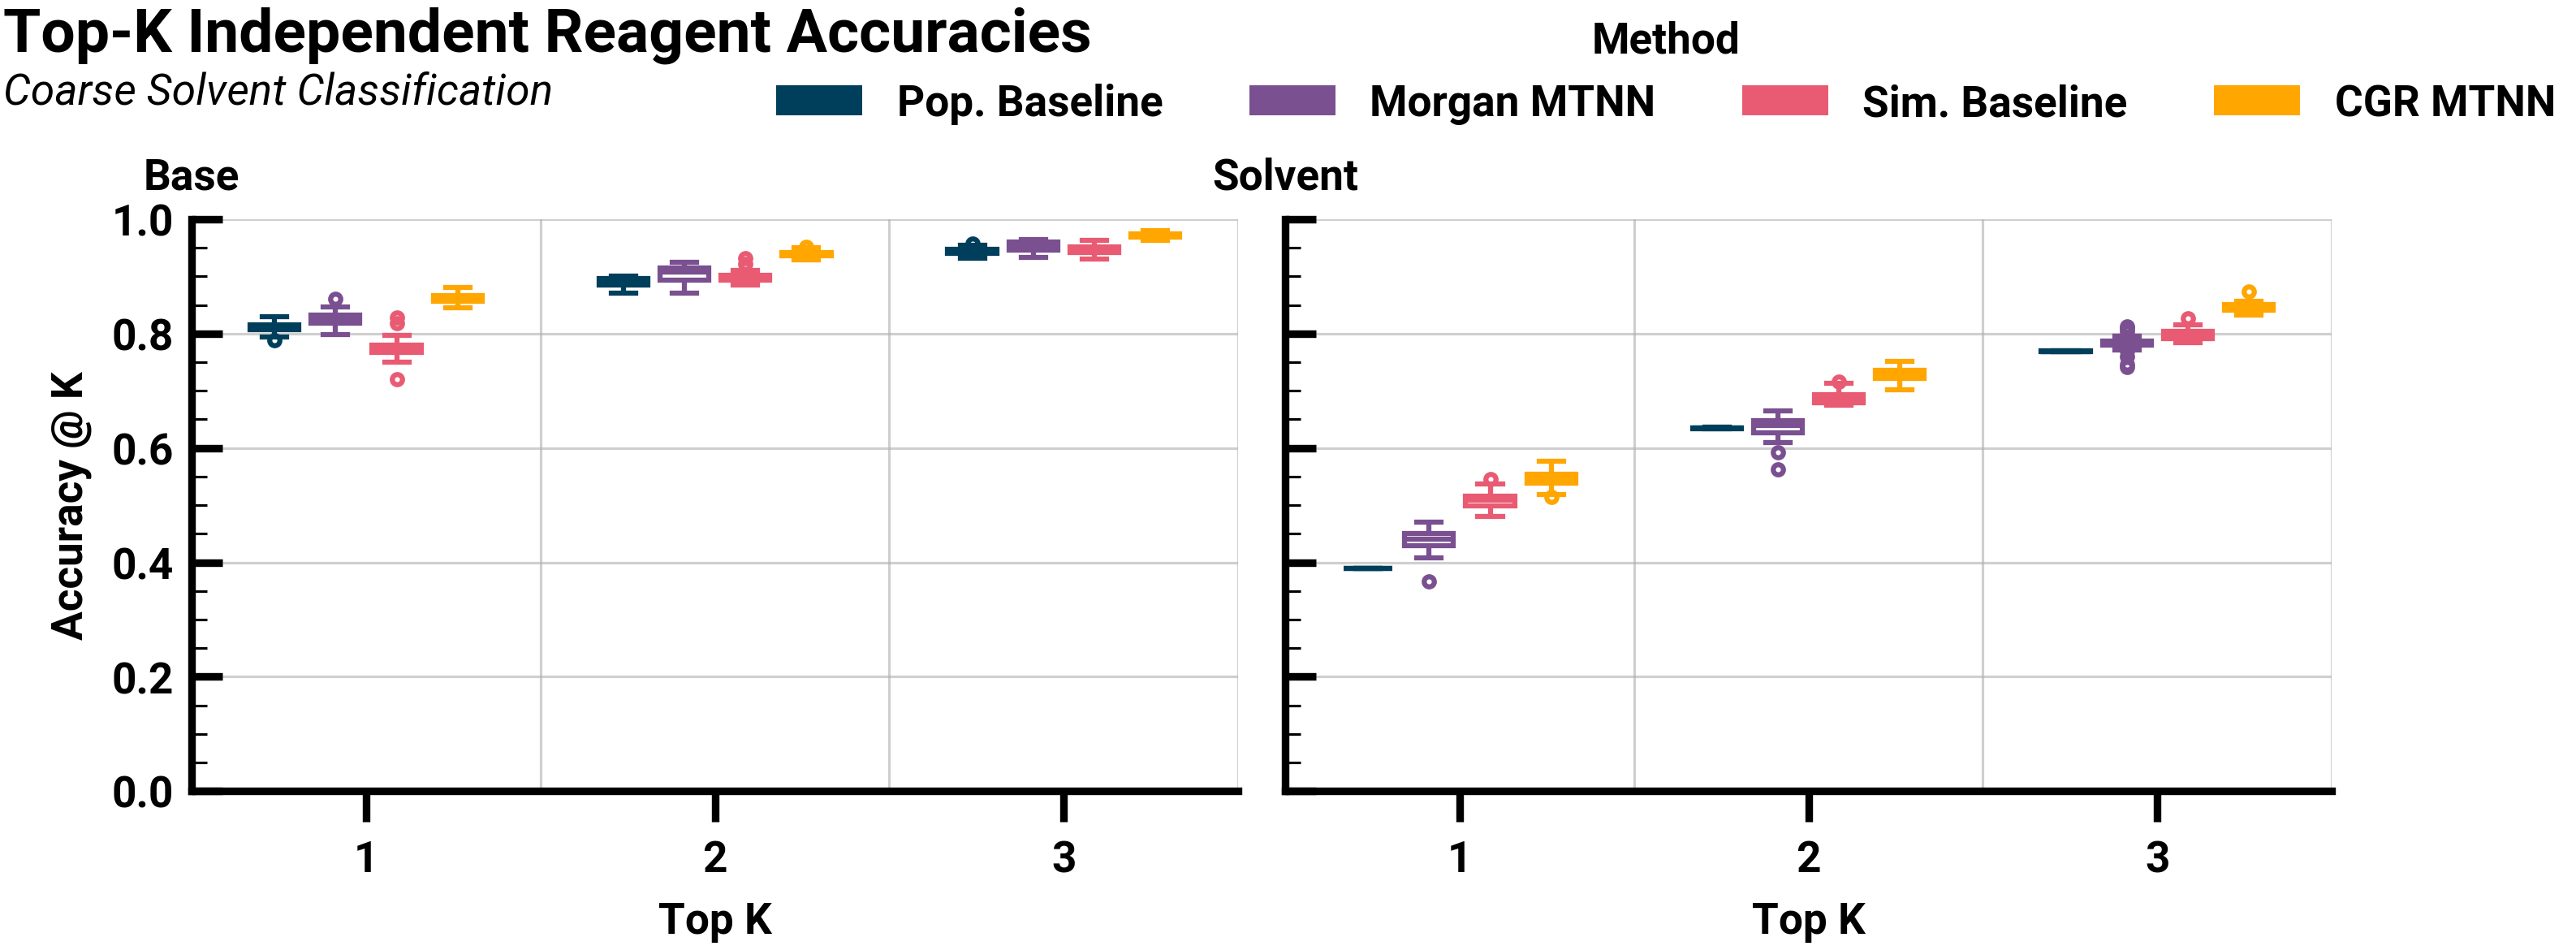

In [11]:
independent_vis_df = independent_top_k_accuracies.filter(pl.col("top_k") <= 3)

n_plots = 2

fig, axs = plot_model_performance(
    vis_df=independent_vis_df,
    reagent_types=["Base", "Solvent"],
    hue_order=["Pop. Baseline", "Morgan MTNN", "Sim. Baseline", "CGR MTNN"],
    figsize=(3.5 * n_plots - (n_plots - 1) * 0.5, 2.69),
    palette=palette,
    share_y=True,
)

for ax in axs:
    ax.tick_params(axis="x", which="both", direction="out")
    ax.set_ylim(0, 1)

add_titles(
    fig=fig,
    title="Top-K Independent Reagent Accuracies",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification",
)

create_fig_legend(fig, axs, n_cols=4, fill_legend=fill_legend)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies/top_k_accuracies_independent.svg",
    bbox_inches="tight",
)


/tmp/ipykernel_1729705/2279451887.py:27: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


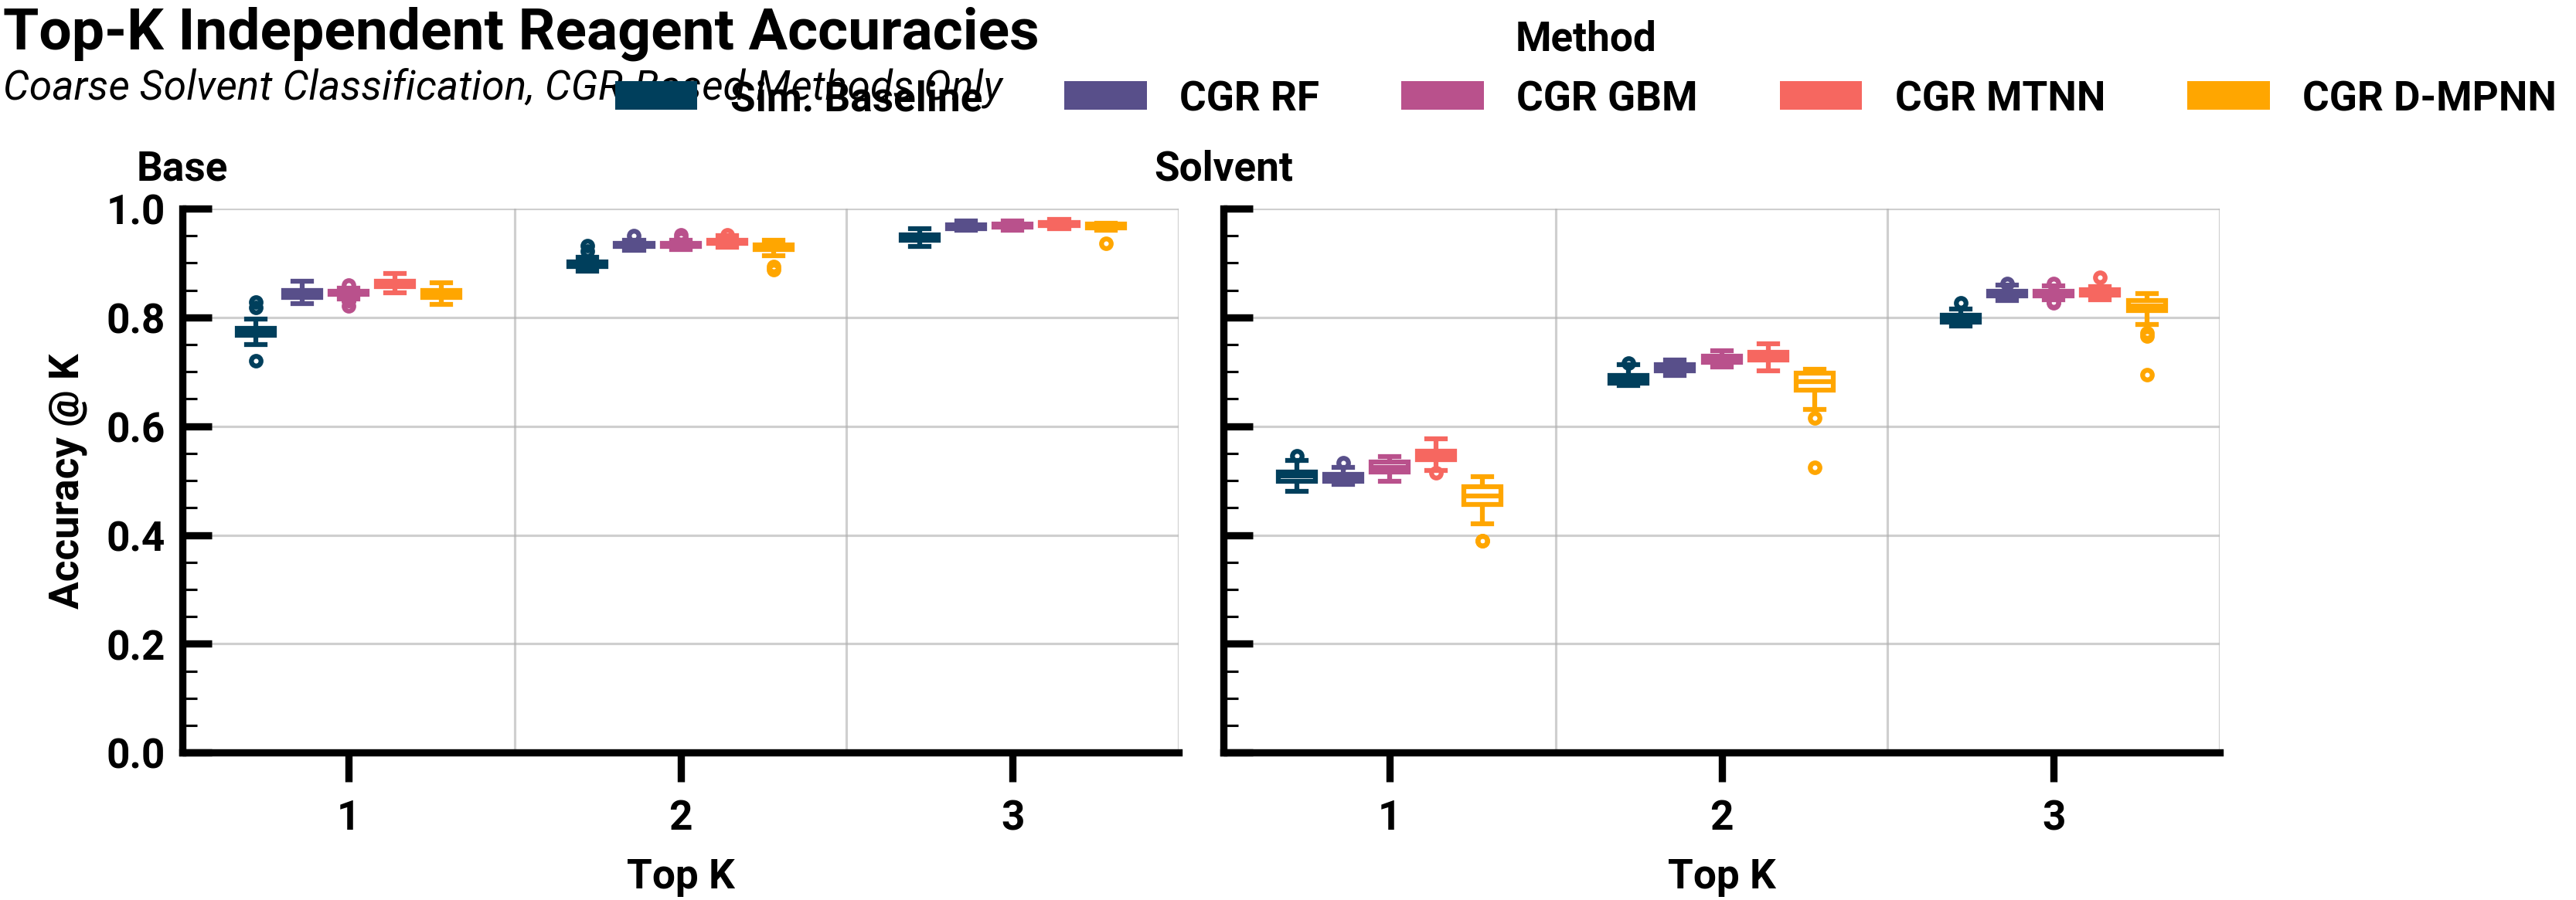

In [12]:
fig, axs = plot_model_performance(
    vis_df=independent_vis_df,
    reagent_types=["Base", "Solvent"],
    hue_order=["Sim. Baseline", "CGR RF", "CGR GBM", "CGR MTNN", "CGR D-MPNN"],
    figsize=(3.5 * n_plots - (n_plots - 1) * 0.5, 2.69),
    despine=True,
    palette=cgr_only_palette,
)

for ax in axs:
    ax.tick_params(axis="x", which="both", direction="out")
    ax.set_ylim(0, 1)

add_titles(
    fig=fig,
    title="Top-K Independent Reagent Accuracies",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification, CGR-Based Methods Only",
)

create_fig_legend(
    fig,
    axs,
    n_cols=5,
    fill_legend=fill_legend,
)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/accuracies/top_k_accuracies_independent_cgr_only.svg",
    bbox_inches="tight",
)

## Performing Statistical Analysis of Results

---

Of course, we need to understand whether these results are significant, therefore we can implement some of the methods for assessing this as described [here](https://chemrxiv.org/engage/api-gateway/chemrxiv/assets/orp/resource/item/672a91bd7be152b1d01a926b/original/practically-significant-method-comparison-protocols-for-machine-learning-in-small-molecule-drug-discovery.pdf) and implemented [here](https://www.blopig.com/blog/2024/12/visualising-and-validating-differences-between-machine-learning-models-on-small-benchmark-datasets/):


Before performing any statistical tests, we need to understand whether we can use parametric tests:

We first test for homogenuity of variances:


In [13]:
metrics = ["accuracy"]
reagent_types = ["Base", "Solvent", "Overall"]
top_ks = [1, 2, 3]

n_metrics = len(metrics) * len(reagent_types) * len(top_ks)

for metric in metrics:
    for reagent_type in reagent_types:
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            groups = (
                df.filter(
                    (pl.col("reagent_type") == reagent_type)
                    & (pl.col("top_k") == top_k)
                    & (pl.col("method") != "Pop. Baseline")
                )
                .group_by("method")
                .agg(pl.col(metric))[metric]
                .to_list()
            )

            stat, pvalue = levene(*groups)

            print(
                f"{reagent_type} @ {top_k} {metric} Levene's Test: p-value = {pvalue}"
            )

Base @ 1 accuracy Levene's Test: p-value = 0.025851211245025867
Base @ 2 accuracy Levene's Test: p-value = 0.0007694618364315133
Base @ 3 accuracy Levene's Test: p-value = 0.022963137275056732
Solvent @ 1 accuracy Levene's Test: p-value = 0.0003991799450428231
Solvent @ 2 accuracy Levene's Test: p-value = 0.0004503354479138649
Solvent @ 3 accuracy Levene's Test: p-value = 0.007110432884105872
Overall @ 1 accuracy Levene's Test: p-value = 0.0005819619969484865
Overall @ 2 accuracy Levene's Test: p-value = 0.001877836074737872
Overall @ 3 accuracy Levene's Test: p-value = 0.02103962650360496


In [14]:
for metric in metrics:
    for reagent_type in reagent_types:
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            groups = (
                # Including Pop. Baseline for variance ratio shouldn't be done, since we expect the variance to be very small.
                df.filter(
                    (pl.col("reagent_type") == reagent_type)
                    & (pl.col("top_k") == top_k)
                    & ~(pl.col("method").is_in(["Pop. Baseline"]))
                )
                .group_by("method")
                .agg(pl.var(metric))
            ).sort(metric, descending=True)

            print(
                f"{reagent_type} @ {top_k} {metric.title()} Max Variance Ratio: {groups[metric][0] / groups[metric][-1]:.3f}",
                f"{groups['method'][0]}, {groups['method'][-1]}",
            )

Base @ 1 Accuracy Max Variance Ratio: 6.454 Sim. Baseline, CGR MTNN
Base @ 2 Accuracy Max Variance Ratio: 7.281 Morgan MTNN, CGR RF
Base @ 3 Accuracy Max Variance Ratio: 4.011 Morgan MTNN, CGR MTNN
Solvent @ 1 Accuracy Max Variance Ratio: 10.644 CGR D-MPNN, CGR RF
Solvent @ 2 Accuracy Max Variance Ratio: 24.068 CGR D-MPNN, CGR RF
Solvent @ 3 Accuracy Max Variance Ratio: 18.735 CGR D-MPNN, CGR RF
Overall @ 1 Accuracy Max Variance Ratio: 13.229 CGR D-MPNN, CGR RF
Overall @ 2 Accuracy Max Variance Ratio: 18.567 CGR D-MPNN, CGR RF
Overall @ 3 Accuracy Max Variance Ratio: 12.795 CGR D-MPNN, CGR RF


Our results violate the assumption of homengenuity of variances, so we must use a non-parametric test, we test for normality anyway:


### Performing Non-Parametric Test


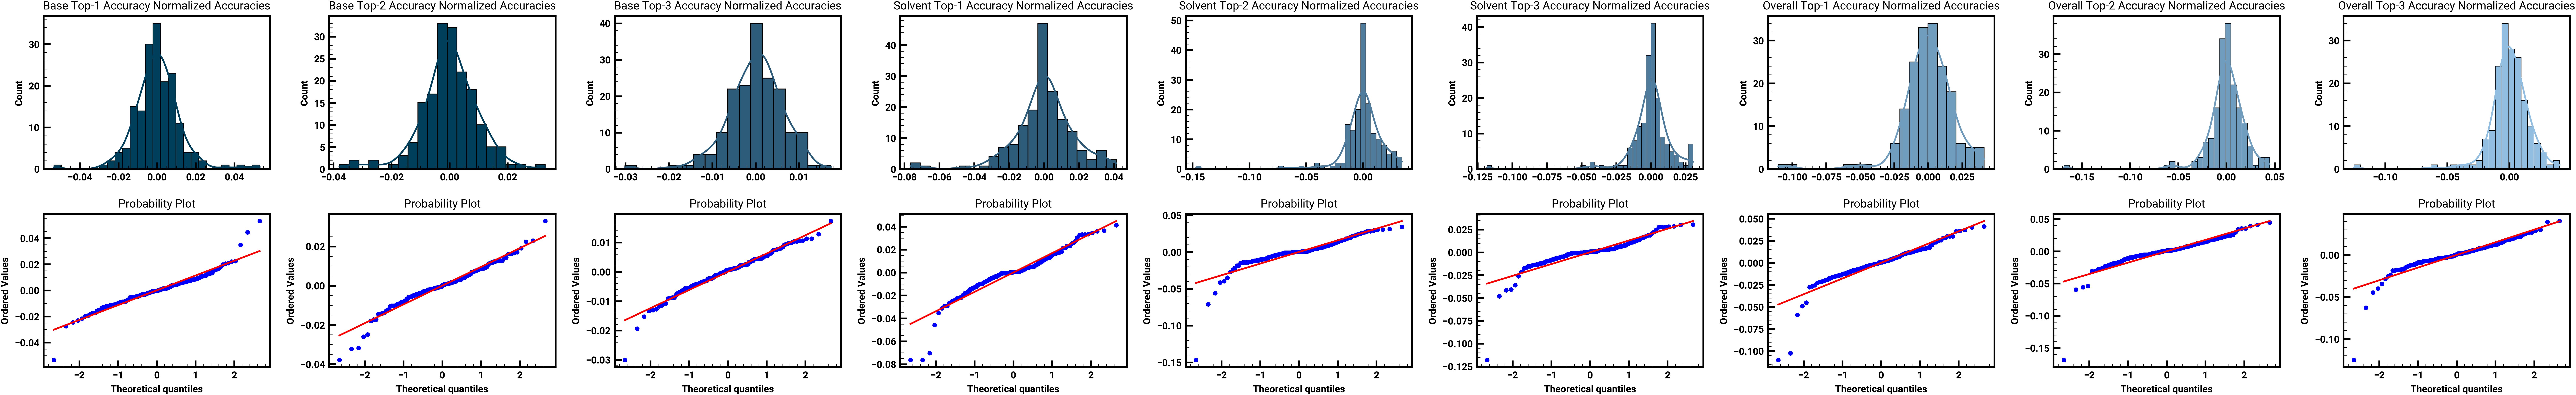

/tmp/ipykernel_1729705/4270601231.py:58: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


In [15]:
fig, axs = plt.subplots(nrows=2, ncols=n_metrics, figsize=(n_metrics * 3.5, 5))

i = 0
for metric in metrics:
    for reagent_type in reagent_types:
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            mean_accs = (
                df.filter(
                    (pl.col("reagent_type") == reagent_type)
                    & (pl.col("top_k") == top_k)
                )
                .group_by("method")
                .mean()
                .select("method", "accuracy")
                .rename({"accuracy": "mean_accuracy"})
            )

            norm_accs = (
                df.filter(
                    (pl.col("reagent_type") == reagent_type)
                    & (pl.col("top_k") == top_k)
                )
                .join(mean_accs, on="method")
                .with_columns(
                    (pl.col("accuracy") - pl.col("mean_accuracy")).alias(
                        "norm_accuracy"
                    )
                )
            )

            sns.histplot(
                norm_accs["norm_accuracy"].to_numpy(),
                color=SYNTHWAVE_SINGLE_HUE_PALETTE[i // 2],
                kde=True,
                ax=axs[0, i],
                alpha=1,
            )

            probplot(
                norm_accs["norm_accuracy"].to_numpy(),
                dist="norm",
                plot=axs[1, i],
            )

            axs[0, i].set_title(
                f"{reagent_type.title()} Top-{top_k} {metric.title()} Normalized Accuracies"
            )

            i += 1

plt.show()

fig.tight_layout()

In [16]:
# We start by first determining the p-values using the Friedman test
import pingouin as pg

for metric in metrics:
    for reagent_type in reagent_types:
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            stat_df = df.filter(
                (pl.col("reagent_type") == reagent_type)
                & (pl.col("top_k") == top_k)
            )

            stat_df = stat_df.with_columns(
                [
                    pl.Series(
                        "split_fold",
                        [
                            f"{split}_{fold}"
                            for split, fold in zip(
                                stat_df["split"].to_numpy(),
                                stat_df["fold"].to_numpy(),
                            )
                        ],
                    )
                ]
            )

            p_value = pg.friedman(
                stat_df.to_pandas(),
                dv=metric,
                within="method",
                subject="split_fold",
            )

            print(
                f"{reagent_type} {metric.title()} @ {top_k} Friedman Test Value: {p_value['p-unc'].values[0]}"
            )

Base Accuracy @ 1 Friedman Test Value: 5.111647098151935e-26
Base Accuracy @ 2 Friedman Test Value: 2.5574017881396065e-23
Base Accuracy @ 3 Friedman Test Value: 2.8508369311913273e-22
Solvent Accuracy @ 1 Friedman Test Value: 3.0003837832799753e-27
Solvent Accuracy @ 2 Friedman Test Value: 2.0347117920658164e-26
Solvent Accuracy @ 3 Friedman Test Value: 5.656110373122303e-25
Overall Accuracy @ 1 Friedman Test Value: 2.550375638105365e-27
Overall Accuracy @ 2 Friedman Test Value: 2.5190575727812775e-27
Overall Accuracy @ 3 Friedman Test Value: 1.9290655014644485e-26


Ok, so the differences are significant, let's see where they are:


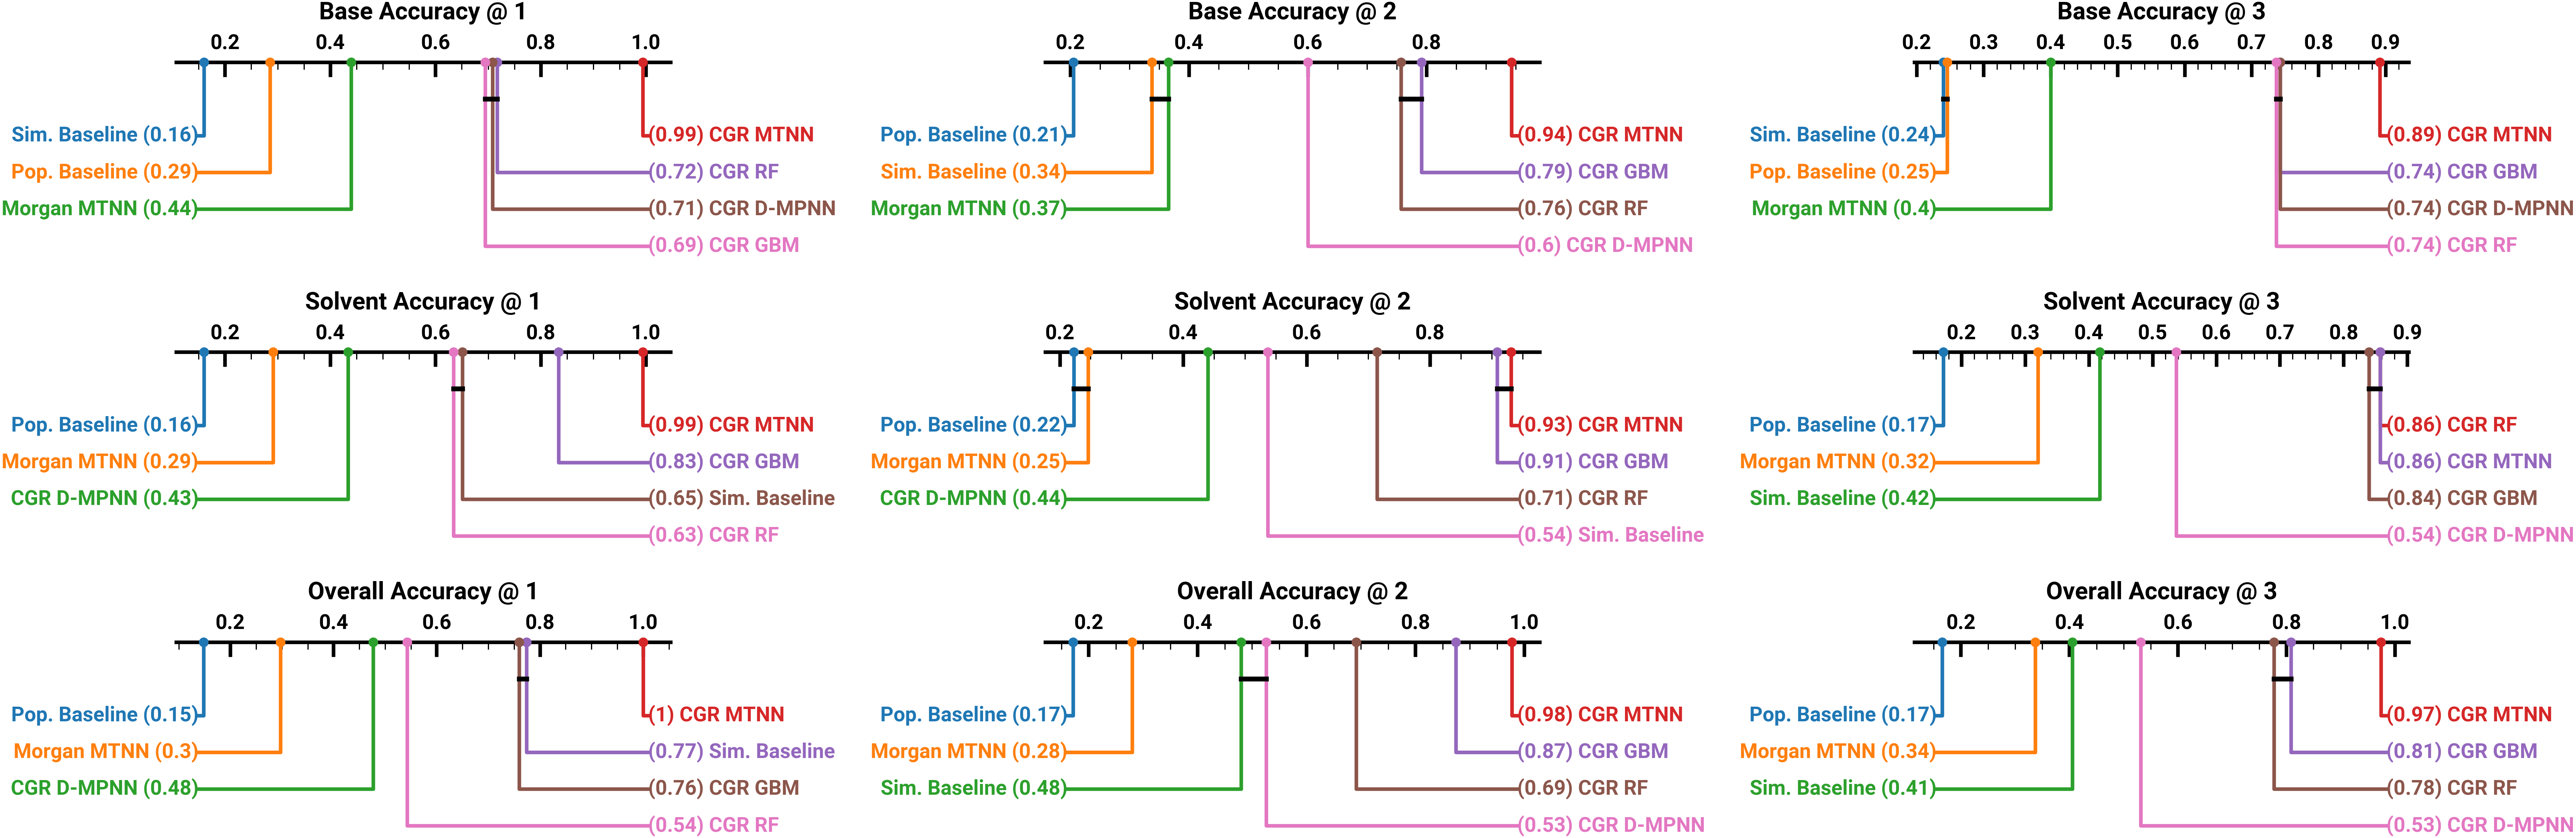

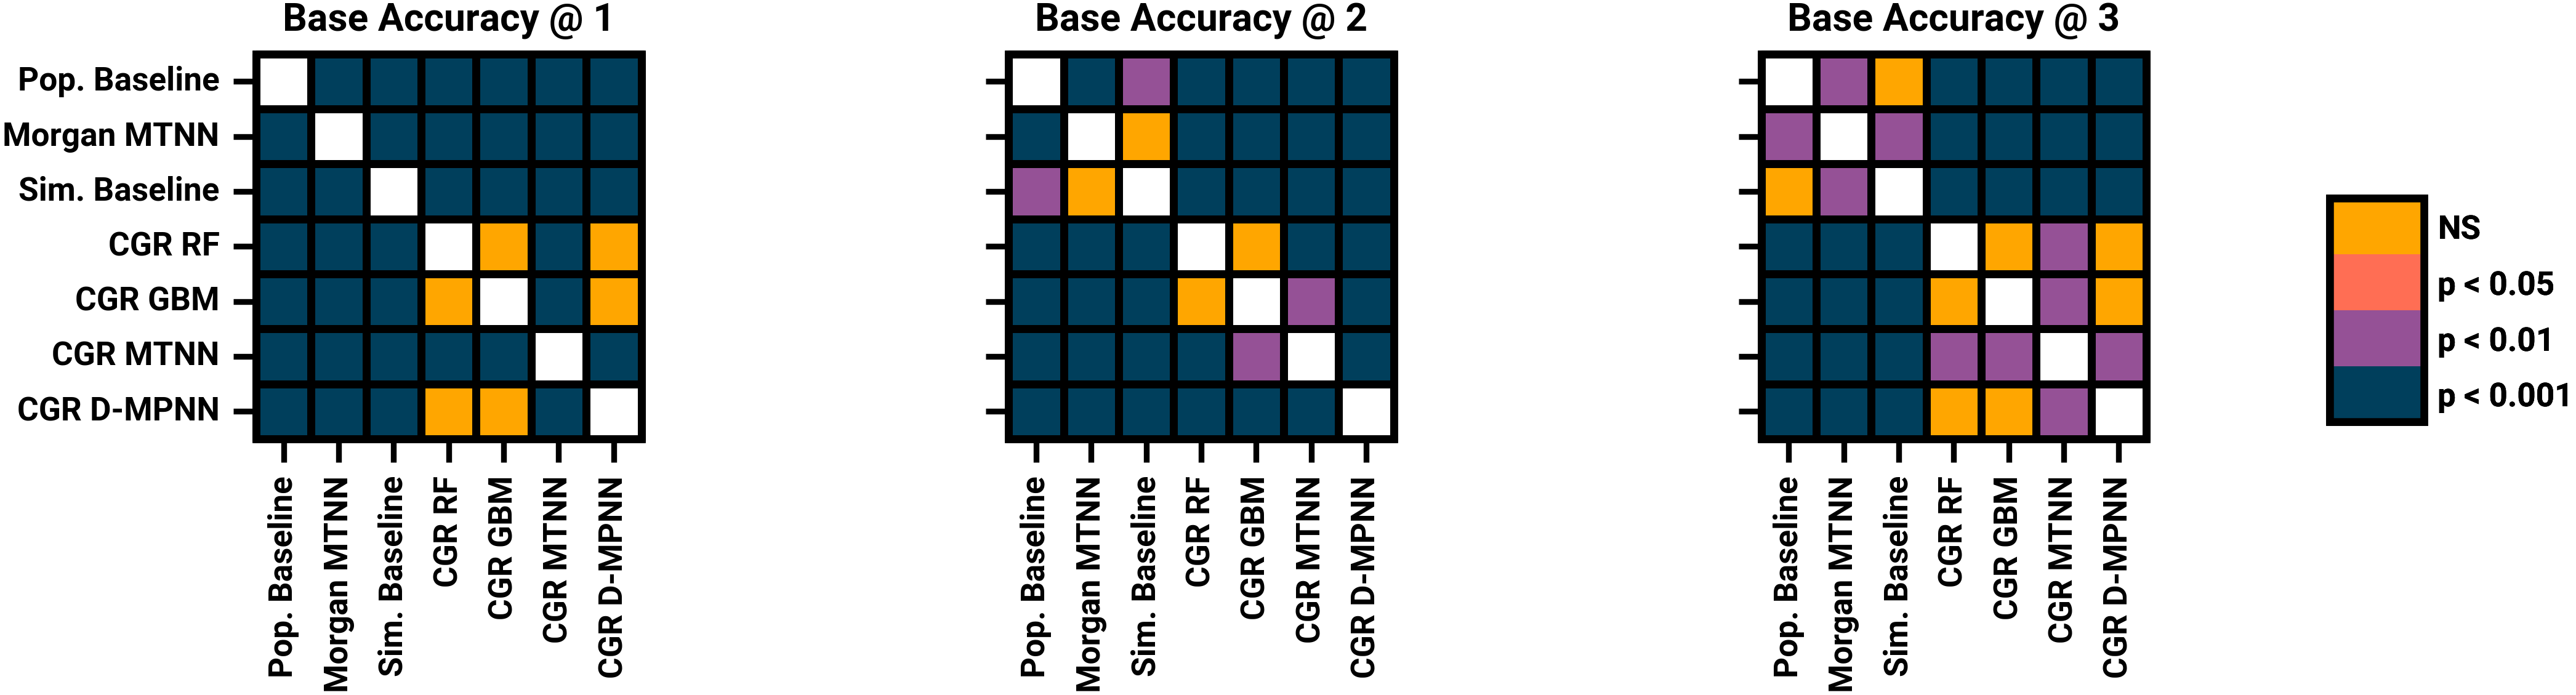

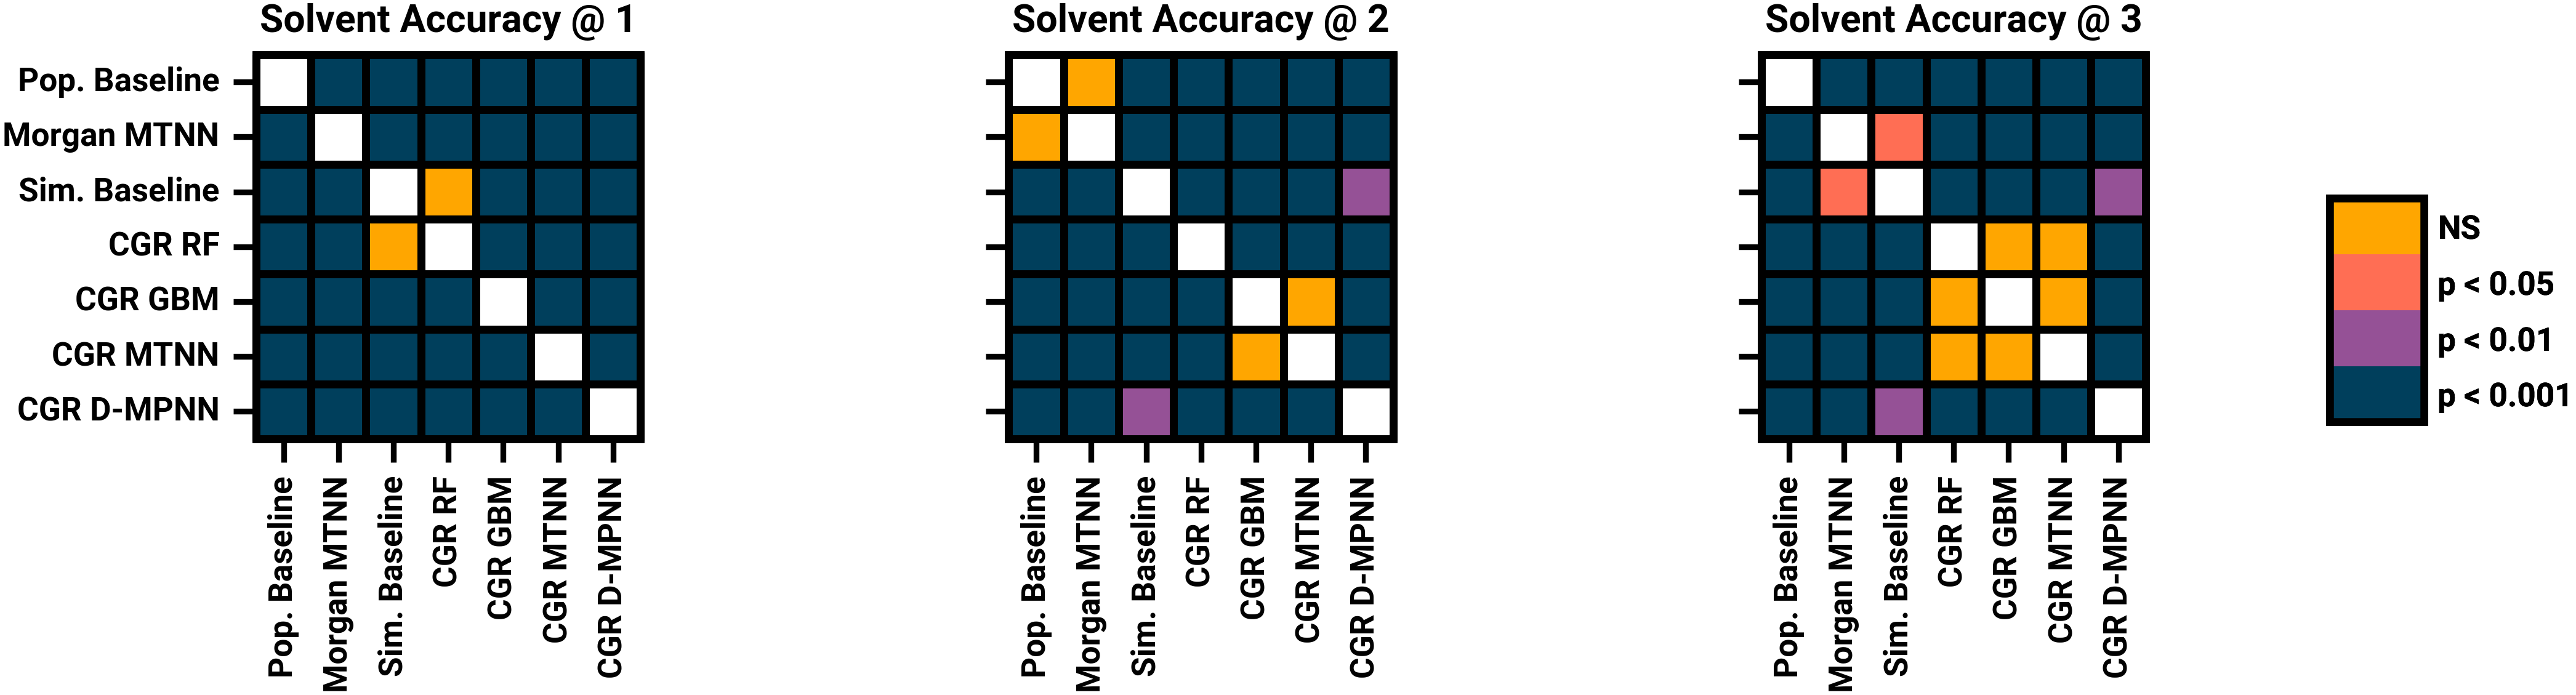

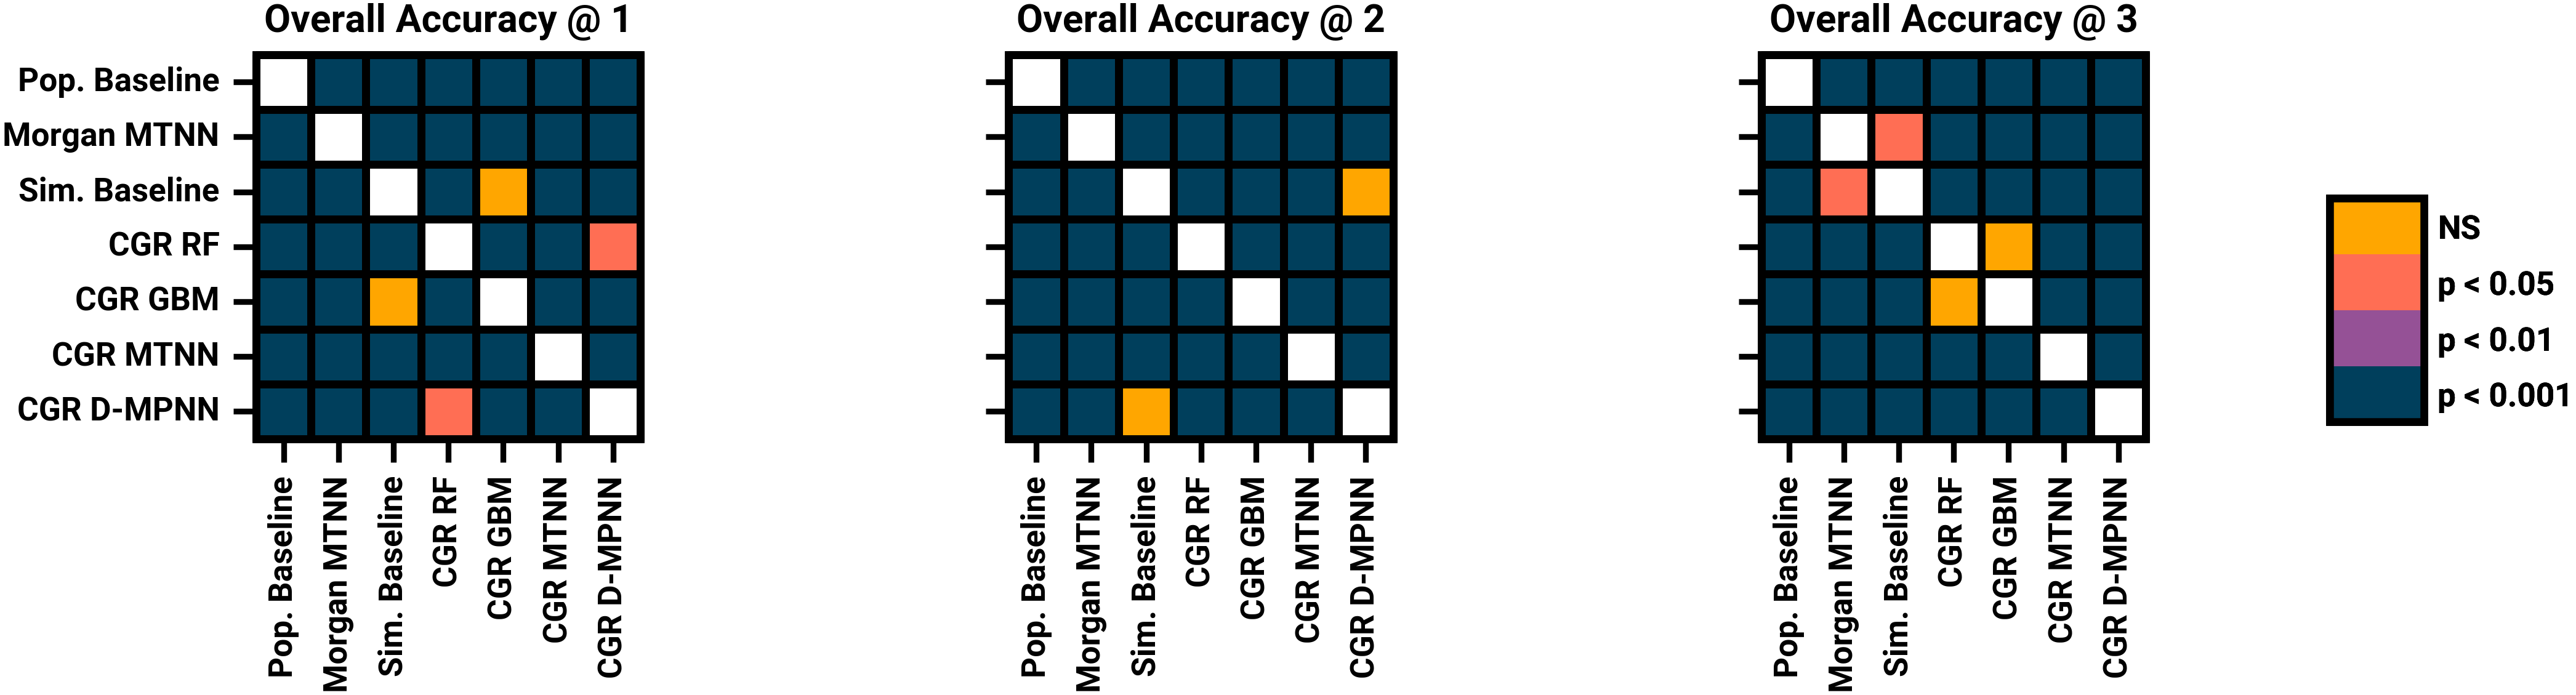

In [17]:
os.makedirs(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/accuracies",
    exist_ok=True,
)

fig, axs = plt.subplots(
    nrows=len(reagent_types),
    ncols=len(top_ks),
    figsize=(len(reagent_types) * 5, len(metrics) * 5),
)

custom_palette = (
    ["1"]
    + [SYNTHWAVE_PALETTE[-1]]
    + [SYNTHWAVE_PALETTE[i] for i in range(0, 5, 2)]
)

for metric in metrics:
    for i, reagent_type in enumerate(reagent_types):
        fig2, axs2 = plt.subplots(
            nrows=1,
            ncols=len(top_ks),
            figsize=(8.5, 2.69),
            sharey=True,
        )
        for top_k in top_ks:
            if reagent_type == "Overall":
                df = vis_df
            else:
                df = independent_vis_df

            metric_name = f"{reagent_type} {metric} @ {top_k}"

            temp_df = df.filter(
                (pl.col("reagent_type") == reagent_type)
                & (pl.col("top_k") == top_k)
            ).to_pandas()

            temp_df["cv"] = [
                (int(row["split"]) - 1) * 5 + int(row["fold"])
                for _, row in temp_df.iterrows()
            ]

            pivot_temp_df = temp_df.pivot(
                index="cv", columns="method", values="accuracy"
            )

            pivot_temp_df = pivot_temp_df[
                [
                    "Pop. Baseline",
                    "Morgan MTNN",
                    "Sim. Baseline",
                    "CGR RF",
                    "CGR GBM",
                    "CGR MTNN",
                    "CGR D-MPNN",
                ]
            ]

            pc = sp.posthoc_conover_friedman(
                pivot_temp_df,
                p_adjust="holm",
            )

            av_rank = (
                temp_df.groupby("cv")
                .accuracy.rank(pct=True)
                .groupby(temp_df.method)
                .mean()
            )

            for j, axs_ in enumerate([axs, axs2]):
                if j == 0:
                    idx = i, top_k - 1
                else:
                    idx = top_k - 1
                axs_[idx].set_title(
                    metric_name.title(),
                    fontdict={"weight": "bold"},
                )

            sp_ax, sp_cb = sp.sign_plot(
                pc,
                ax=axs2[top_k - 1],
                cmap=custom_palette,
                **{
                    "linewidths": 2,
                    "linecolor": "black",
                    "clip_on": False,
                    "square": True,
                    "cbar_ax_bbox": [1, 0.4, 0.04, 0.3],
                },
            )

            sp.critical_difference_diagram(
                ranks=av_rank, sig_matrix=pc, ax=axs[i, top_k - 1]
            )
            for spine in sp_ax.spines.values():
                spine.set_visible(True)
                spine.set_linewidth(2)

            sp_cb.outline.set_color("black")
            sp_cb.outline.set_linewidth(2)

            sp_ax.tick_params(axis="both", which="both", direction="out")
            sp_ax.tick_params(axis="both", which="minor", length=0)

        fig2.savefig(
            f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/accuracies/{reagent_type.lower()}_top_k_{metric}_posthoc.svg",
            bbox_inches="tight",
        )

fig.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/accuracies/critical_difference_diagrams.svg",
    bbox_inches="tight",
)

## Analysis of alternative classification metrics

---

Whilst accuracy is a useful indicator of a classifiers performance, the presence of imbalanced


In [18]:
def process_metrics_df(df: pl.DataFrame) -> pl.DataFrame:
    split_metric_df = df.with_columns(
        pl.col("metric_name").str.split("_").alias("split_metric_name")
    )
    metric_name_df = split_metric_df.with_columns(
        [
            pl.col("split_metric_name")
            .list.gather([-2, -1])
            .alias("split_metric"),
            pl.col("split_metric_name")
            .list.gather([-2, -1])
            .list.join("_")
            .alias("metric"),
        ]
    )
    metric_name_and_reagent_type_df = metric_name_df.with_columns(
        pl.col("split_metric_name")
        .list.set_difference("split_metric")
        .list.join("_")
        .alias("reagent_type")
    )
    final_df = metric_name_and_reagent_type_df.drop(
        ["split_metric_name", "metric_name", "split_metric"]
    )
    return final_df

In [19]:
combined_metrics_df = process_metrics_df(independent_metrics)
combined_metrics_df = combined_metrics_df.with_columns(
    pl.col("reagent_type").replace(
        {
            f"{SOLVENT_CLASSIFICATION}_solvent": "Solvent",
            "base": "Base",
            "overall": "Overall",
        }
    )
)


/tmp/ipykernel_1729705/852916972.py:77: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


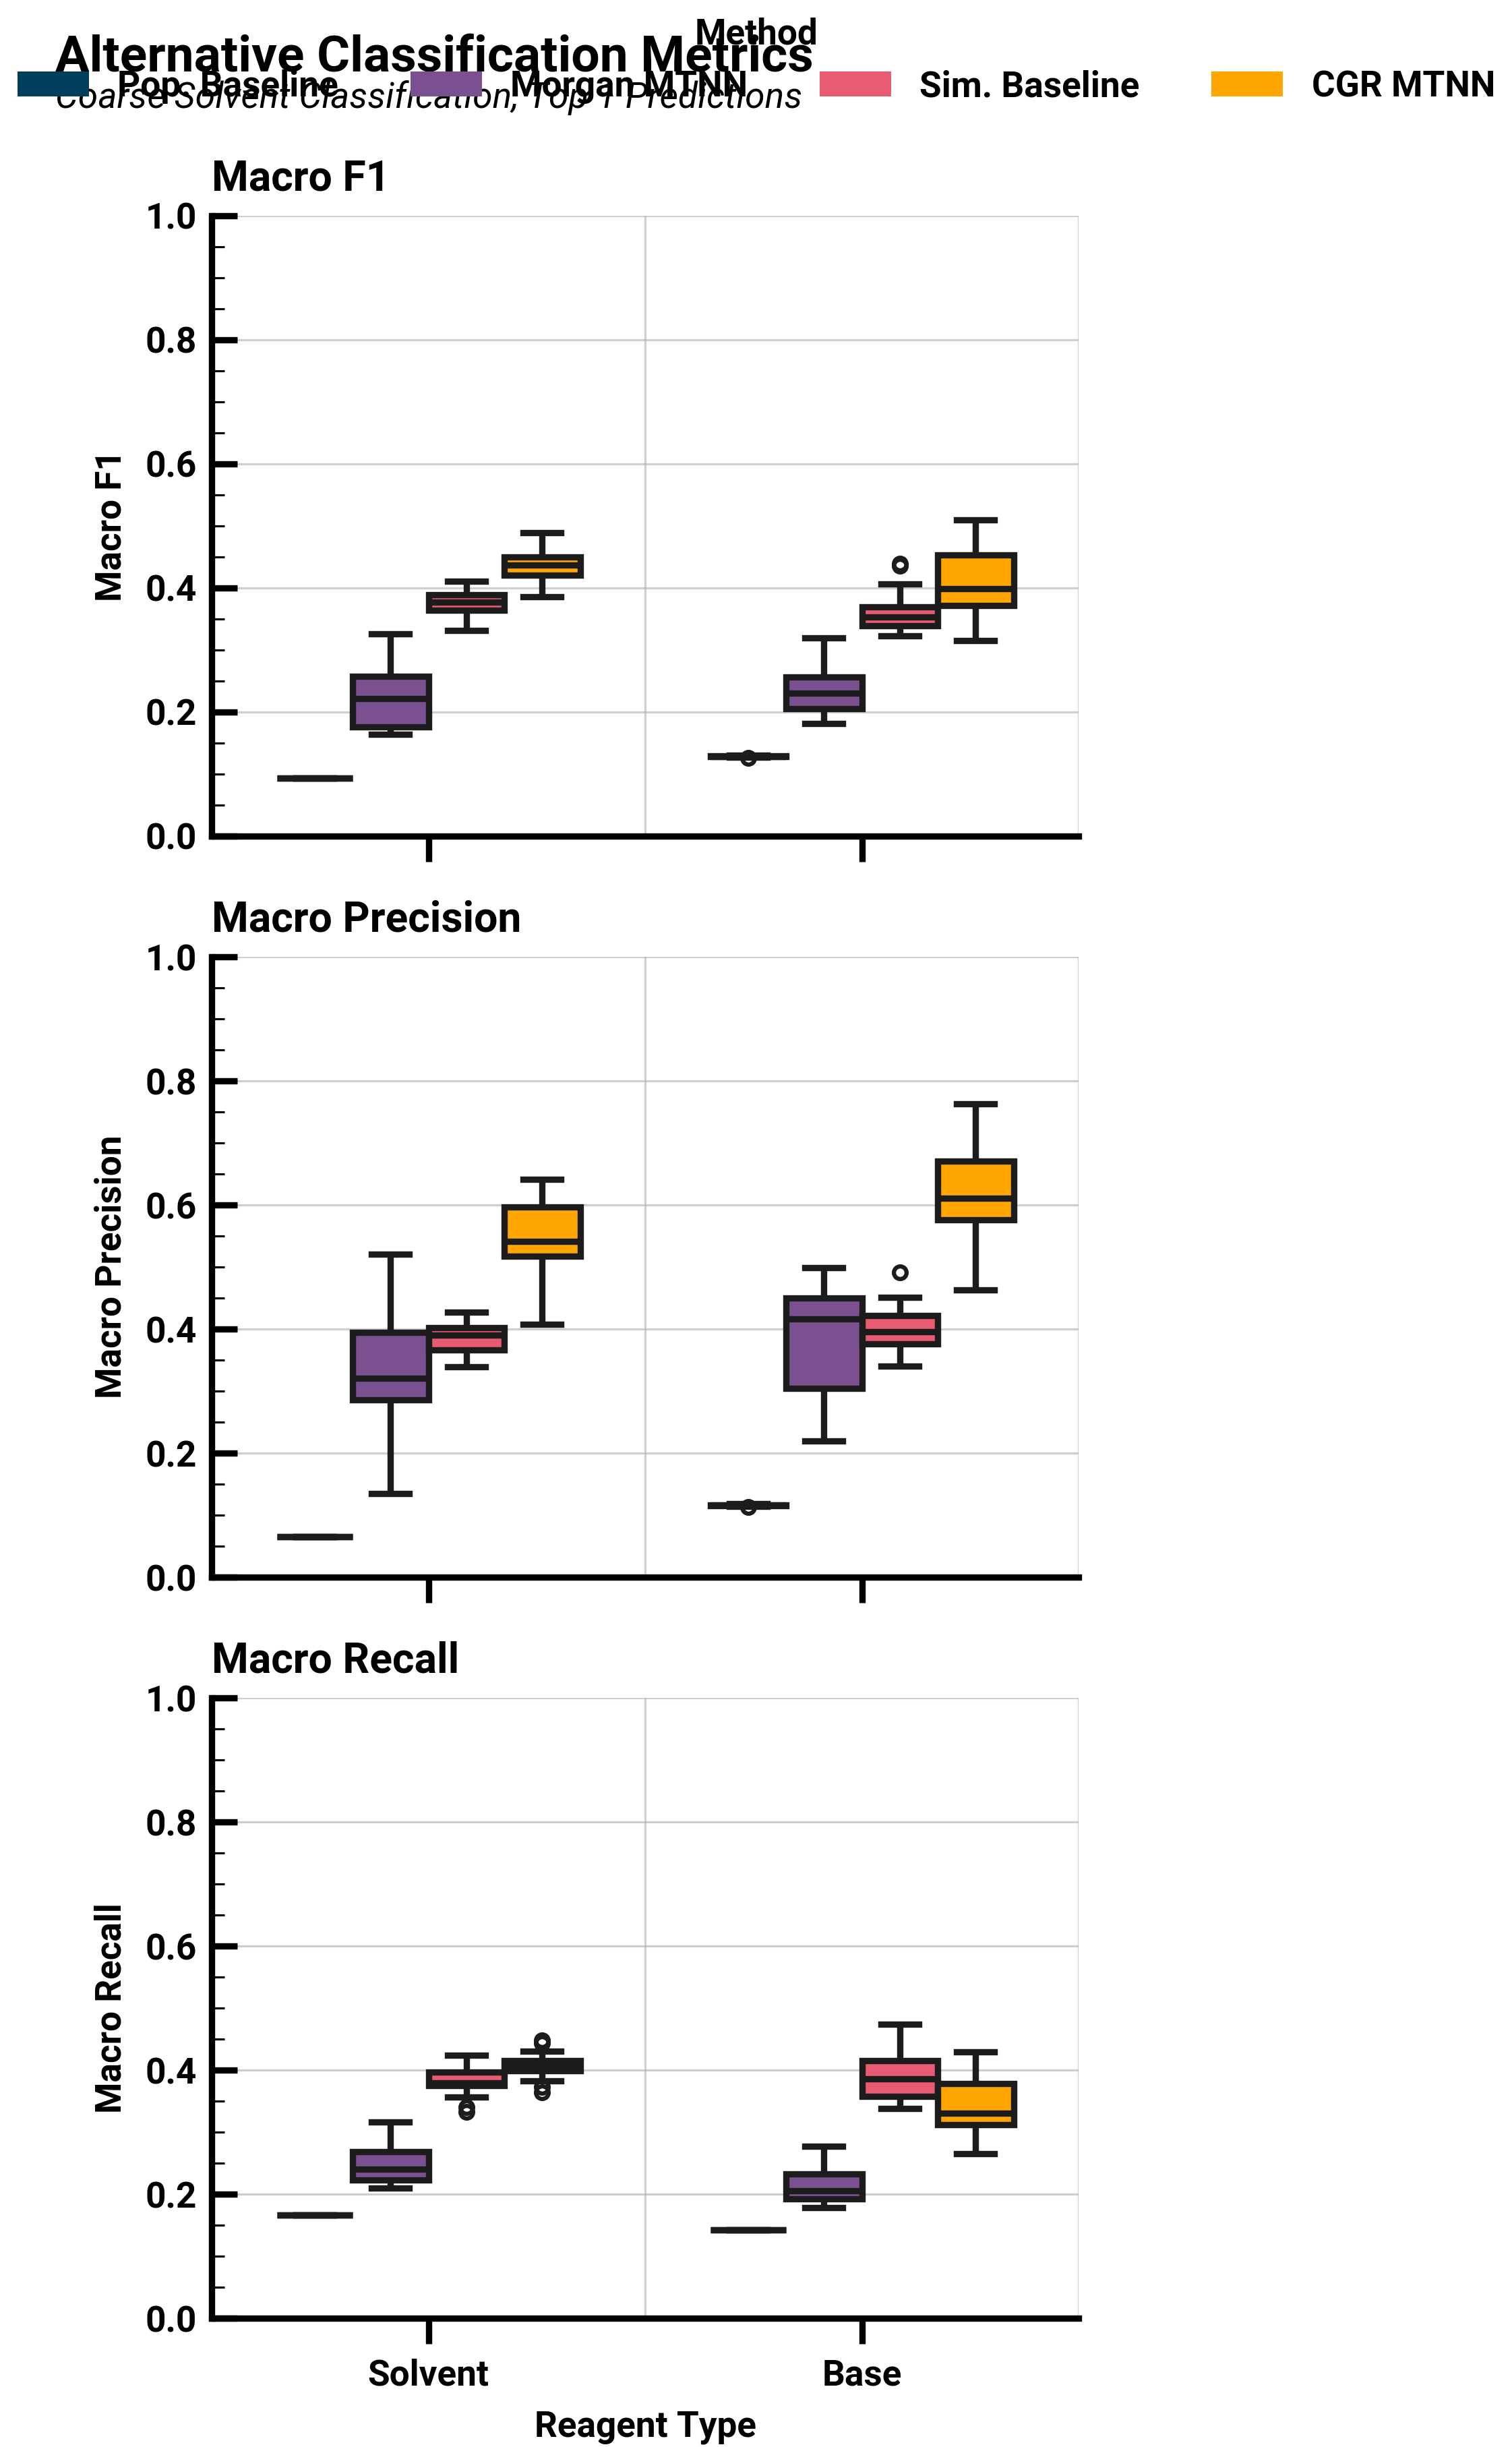

In [20]:
def create_metrics_plot(
    metrics: list, df: pl.DataFrame, hue_order: list, palette: list
):
    fig, axs = plt.subplots(
        nrows=3, figsize=(3.5, 3 * 2.69), sharey=False, sharex=True
    )
    for metric, ax in zip(metrics, axs):
        sns.despine(ax=ax)
        sns.boxplot(
            data=df.filter(pl.col("metric") == metric),
            x="reagent_type",
            y="value",
            hue="method",
            hue_order=hue_order,
            palette=palette,
            linewidth=1.5,
            saturation=1,
            dodge=True,
            ax=ax,
            width=0.7,
        )

        ax.set_xlabel("Reagent Type")
        ax.set_ylabel(f"{metric.replace('_', ' ').title()}")
        ax.set_title(
            metric.replace("_", " ").title(),
            fontdict={"weight": "bold", "ha": "left", "x": 0},
        )

        if ax != axs[-1]:
            ax.get_legend().remove()

        ax.tick_params(axis="x", which="both", direction="out")
        ax.tick_params(axis="x", which="minor", bottom=False)

        ax.grid(axis="y", linestyle="-", alpha=0.6, zorder=0, linewidth=0.5)
        ax.set_xticks(
            [0.5, 1.5],
            minor=True,
        )
        ax.grid(
            which="minor",
            axis="x",
            linestyle="-",
            alpha=0.6,
            zorder=0,
            linewidth=0.5,
        )

        ax.set_ylim(0, 1)

    return fig, axs


fig, axs = create_metrics_plot(
    metrics=["macro_f1", "macro_precision", "macro_recall"],
    df=combined_metrics_df,
    hue_order=["Pop. Baseline", "Morgan MTNN", "Sim. Baseline", "CGR MTNN"],
    palette=palette,
)

add_titles(
    fig=fig,
    title="Alternative Classification Metrics",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification, Top 1 Predictions",
    subtitle_y=0.97,
)

create_fig_legend(
    fig,
    axs,
    n_cols=4,
    fill_legend=True,
    bbox_to_anchor=(0.66, 1.02),
)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/metrics/alternative_classification_metrics.svg",
    bbox_inches="tight",
)

/tmp/ipykernel_1729705/1048399614.py:23: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


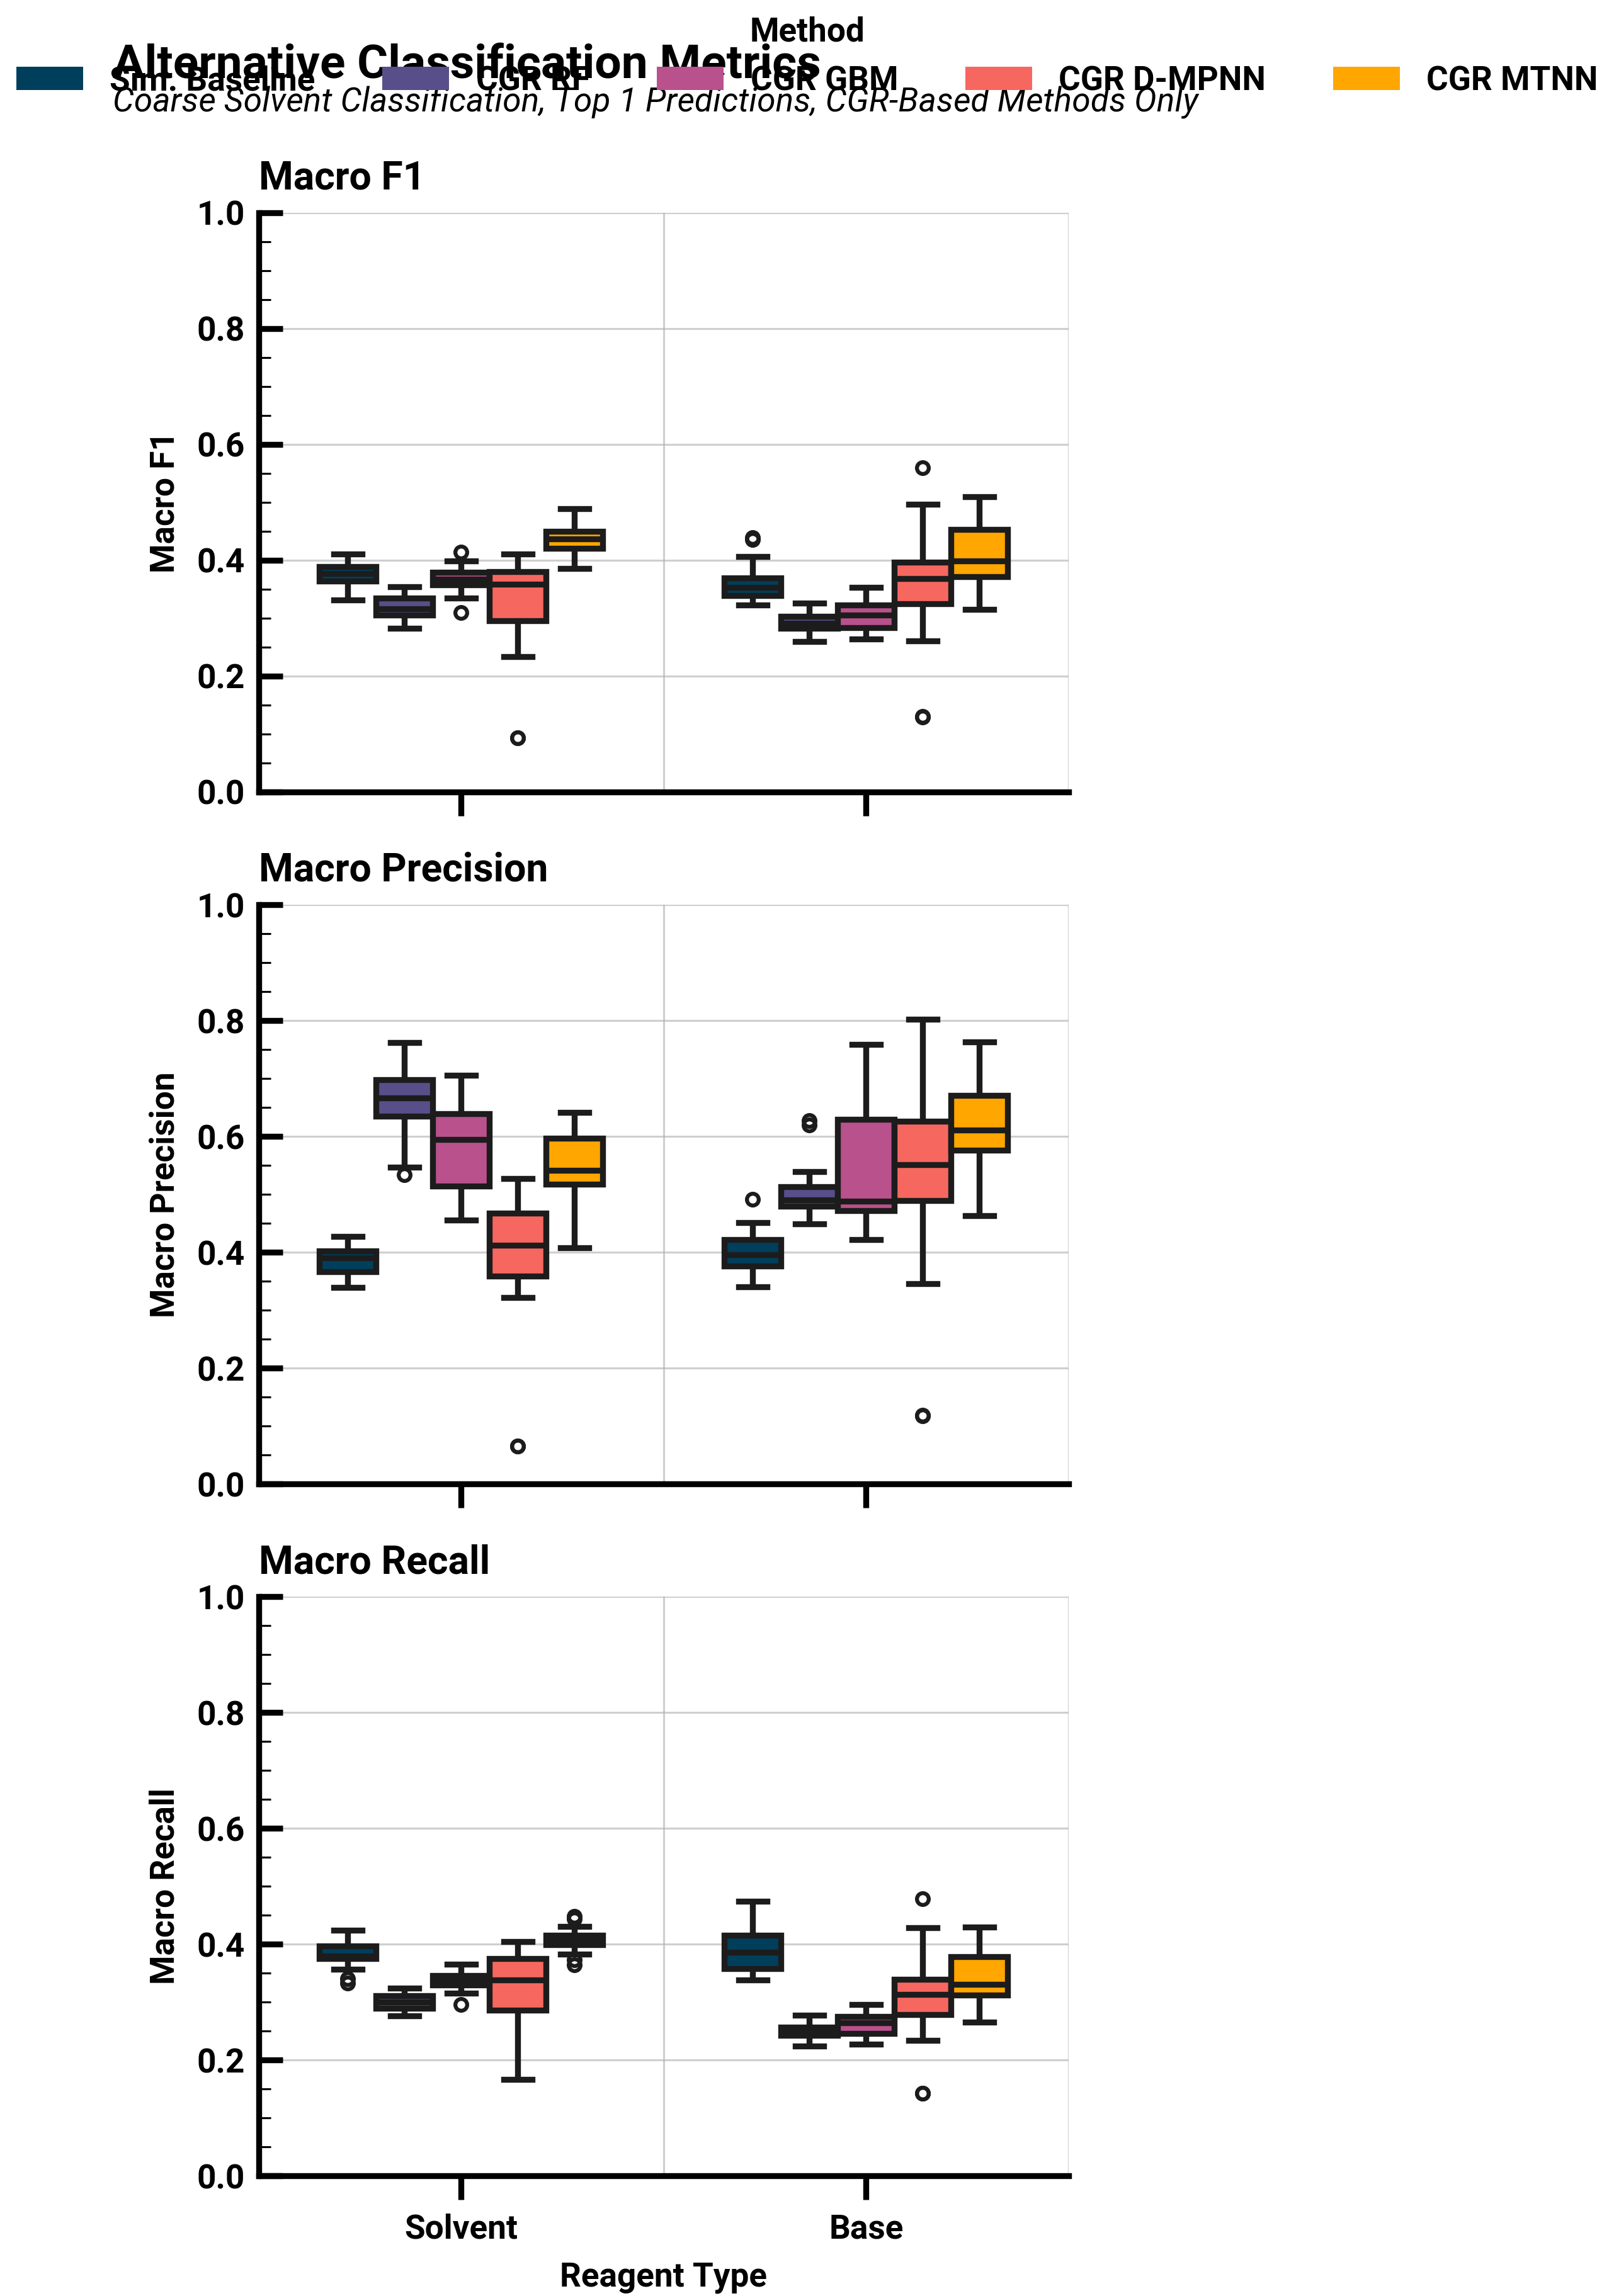

In [21]:
fig, axs = create_metrics_plot(
    metrics=["macro_f1", "macro_precision", "macro_recall"],
    df=combined_metrics_df,
    hue_order=["Sim. Baseline", "CGR RF", "CGR GBM", "CGR D-MPNN", "CGR MTNN"],
    palette=cgr_only_palette,
)

create_fig_legend(
    fig,
    axs,
    n_cols=5,
    fill_legend=True,
    bbox_to_anchor=(0.7, 1.025),
)

add_titles(
    fig=fig,
    title="Alternative Classification Metrics",
    subtitle=f"{SOLVENT_CLASSIFICATION.title()} Solvent Classification, Top 1 Predictions, CGR-Based Methods Only",
    subtitle_y=0.97,
)

fig.tight_layout()

plt.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/metrics/alternative_classification_metrics_cgr_only.svg",
    bbox_inches="tight",
)

We can perform the same tests as above on these metrics instead.

Again, we check for normality:


In [22]:
metrics = ["macro_f1", "macro_precision", "macro_recall"]
reagent_types = ["Base", "Solvent"]

for metric in metrics:
    for reagent_type in reagent_types:
        df = combined_metrics_df.filter(
            (pl.col("reagent_type") == reagent_type)
            & (pl.col("metric") == metric)
            & (pl.col("method") != "Pop. Baseline")
        )

        groups = df.group_by("method").agg(pl.col("value"))["value"].to_list()

        stat, pvalue = levene(*groups)

        print(f"{reagent_type} {metric} Levene's Test: p-value = {pvalue}")

        sorted_vars_by_method = (
            df.group_by("method")
            .agg(pl.var("value"))
            .sort("value", descending=True)
        )

        print(
            f"{reagent_type} {metric.title()} Max Variance Ratio: {sorted_vars_by_method['value'][0] / sorted_vars_by_method['value'][-1]:.3f}"
        )

Base macro_f1 Levene's Test: p-value = 4.5695516099915774e-07
Base Macro_F1 Max Variance Ratio: 35.158
Solvent macro_f1 Levene's Test: p-value = 6.748835068041341e-07
Solvent Macro_F1 Max Variance Ratio: 17.542
Base macro_precision Levene's Test: p-value = 0.00012585588703712848
Base Macro_Precision Max Variance Ratio: 21.710
Solvent macro_precision Levene's Test: p-value = 0.0004664715023054563
Solvent Macro_Precision Max Variance Ratio: 24.253
Base macro_recall Levene's Test: p-value = 2.762310485371945e-06
Base Macro_Recall Max Variance Ratio: 30.616
Solvent macro_recall Levene's Test: p-value = 8.423688688870755e-09
Solvent Macro_Recall Max Variance Ratio: 21.620


Again, we need to use non-parametric tests:


In [23]:
for metric in metrics:
    for reagent_type in reagent_types:
        df = combined_metrics_df.filter(
            (pl.col("reagent_type") == reagent_type)
            & (pl.col("metric") == metric)
        )

        stat_df = df.with_columns(
            [
                pl.Series(
                    "split_fold",
                    [
                        f"{split}_{fold}"
                        for split, fold in zip(
                            df["split"].to_numpy(),
                            df["fold"].to_numpy(),
                        )
                    ],
                )
            ]
        )

        p_value = pg.friedman(
            stat_df.to_pandas(),
            dv="value",
            within="method",
            subject="split_fold",
        )["p-unc"].values[0]

        print(
            f"{reagent_type} {metric.title()} Friedman Test Value: {p_value}"
        )

Base Macro_F1 Friedman Test Value: 4.7467737243038603e-23
Solvent Macro_F1 Friedman Test Value: 5.899831878309329e-26
Base Macro_Precision Friedman Test Value: 4.512830270238873e-22
Solvent Macro_Precision Friedman Test Value: 2.286031203492905e-26
Base Macro_Recall Friedman Test Value: 2.4038570884571347e-25
Solvent Macro_Recall Friedman Test Value: 9.230291463892194e-27


Once again, all of the metrics contain some significant difference, let's work out where:


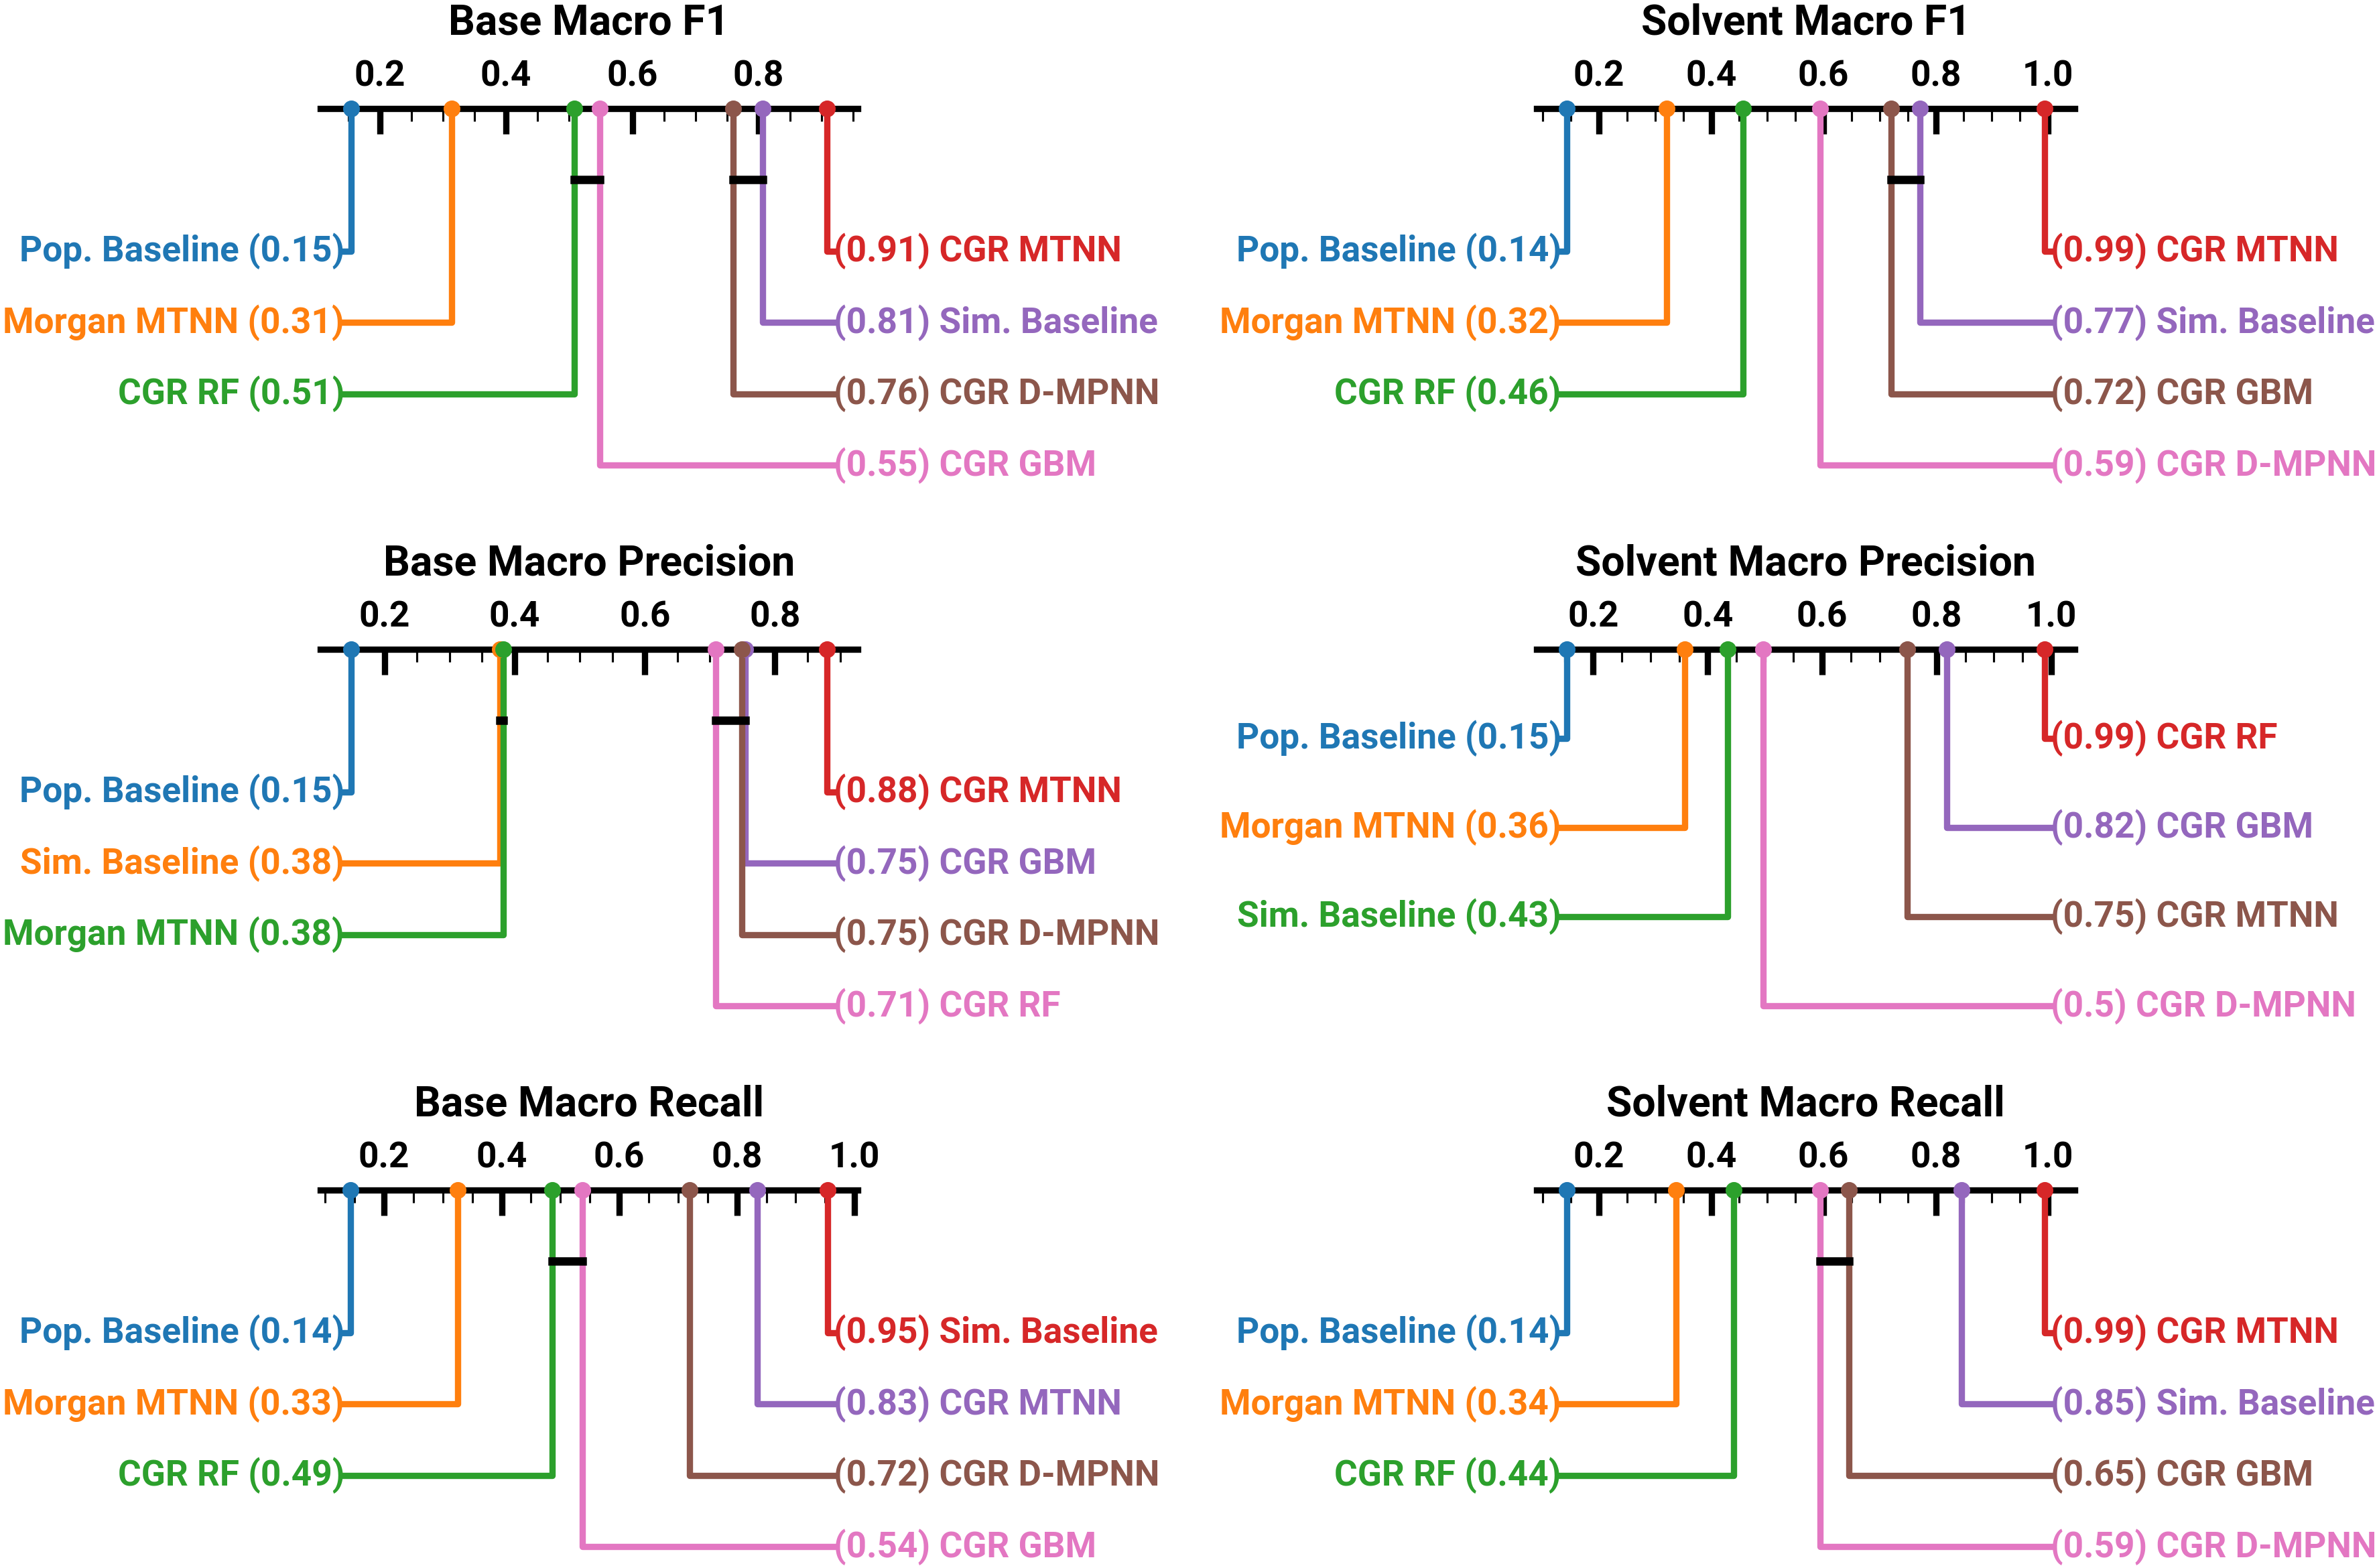

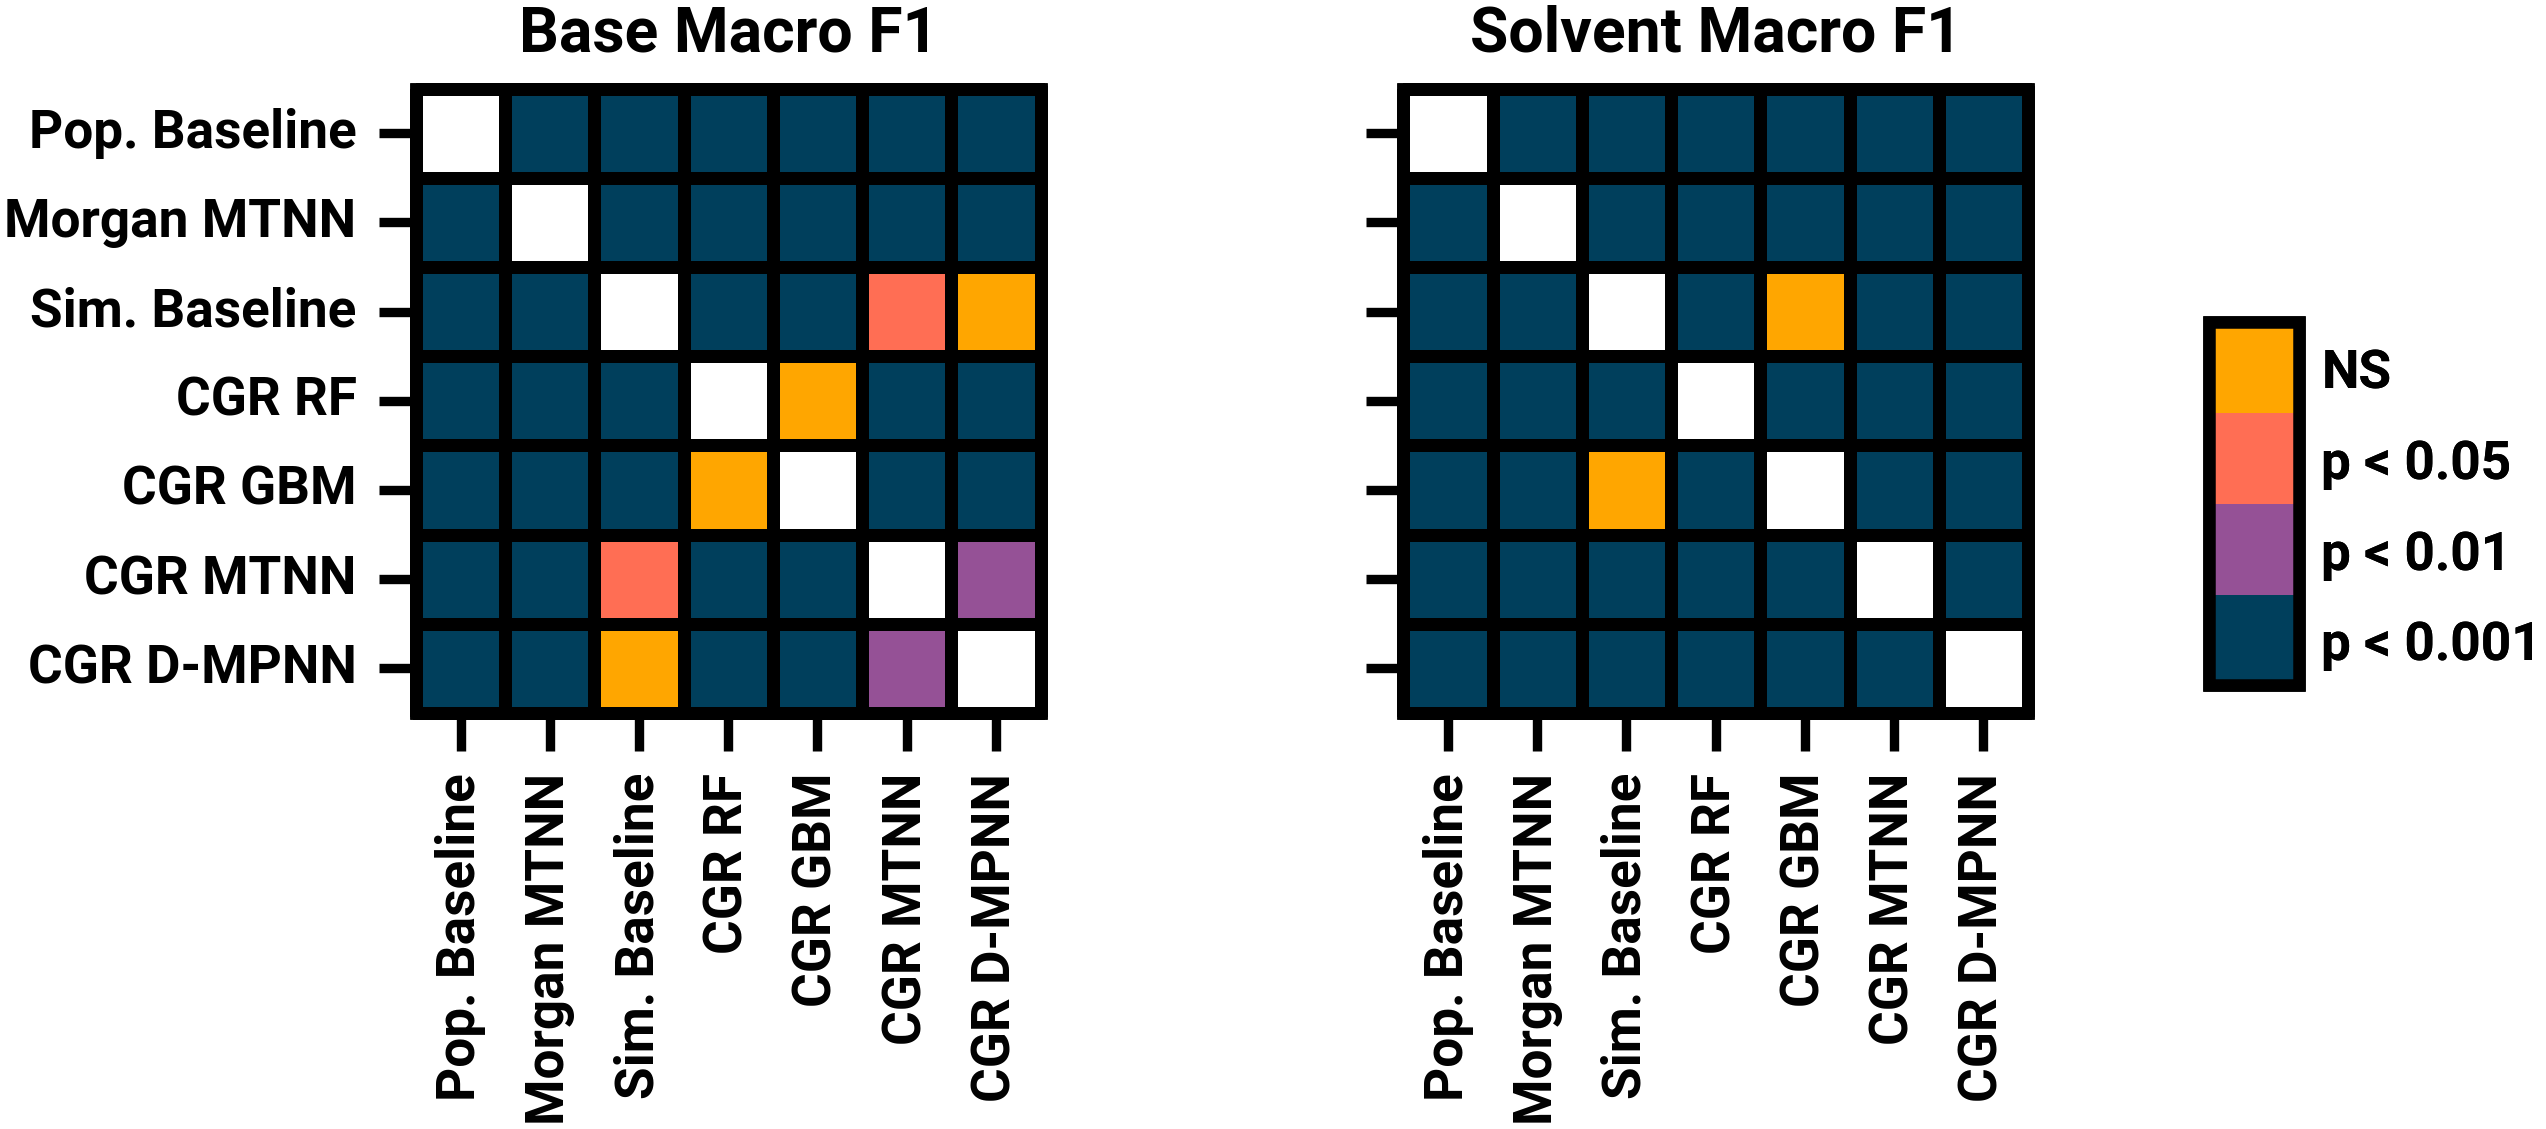

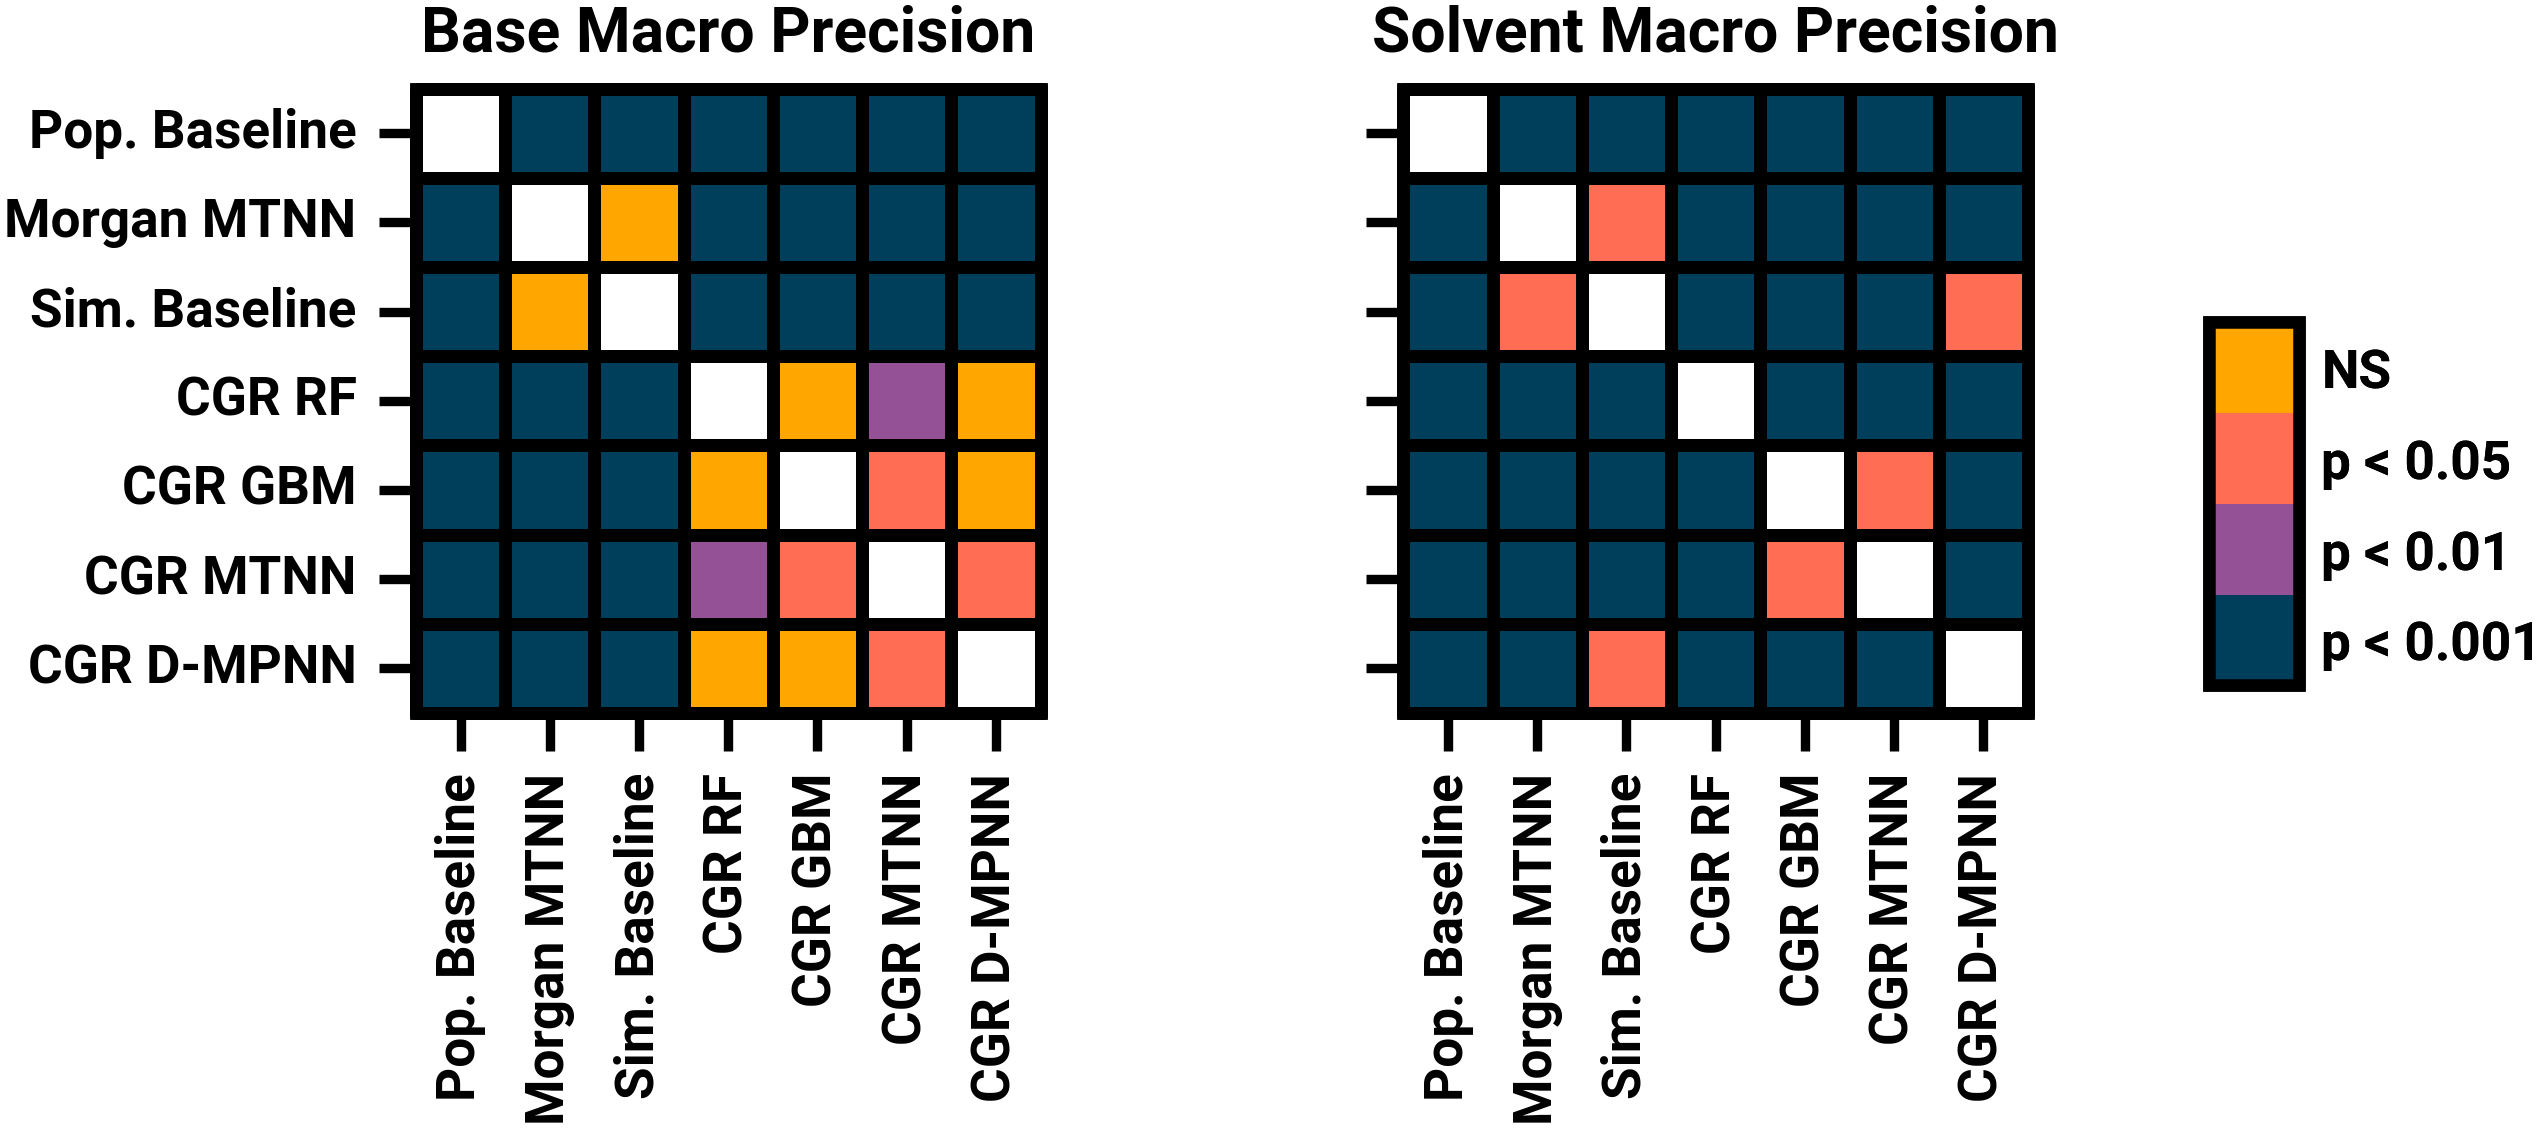

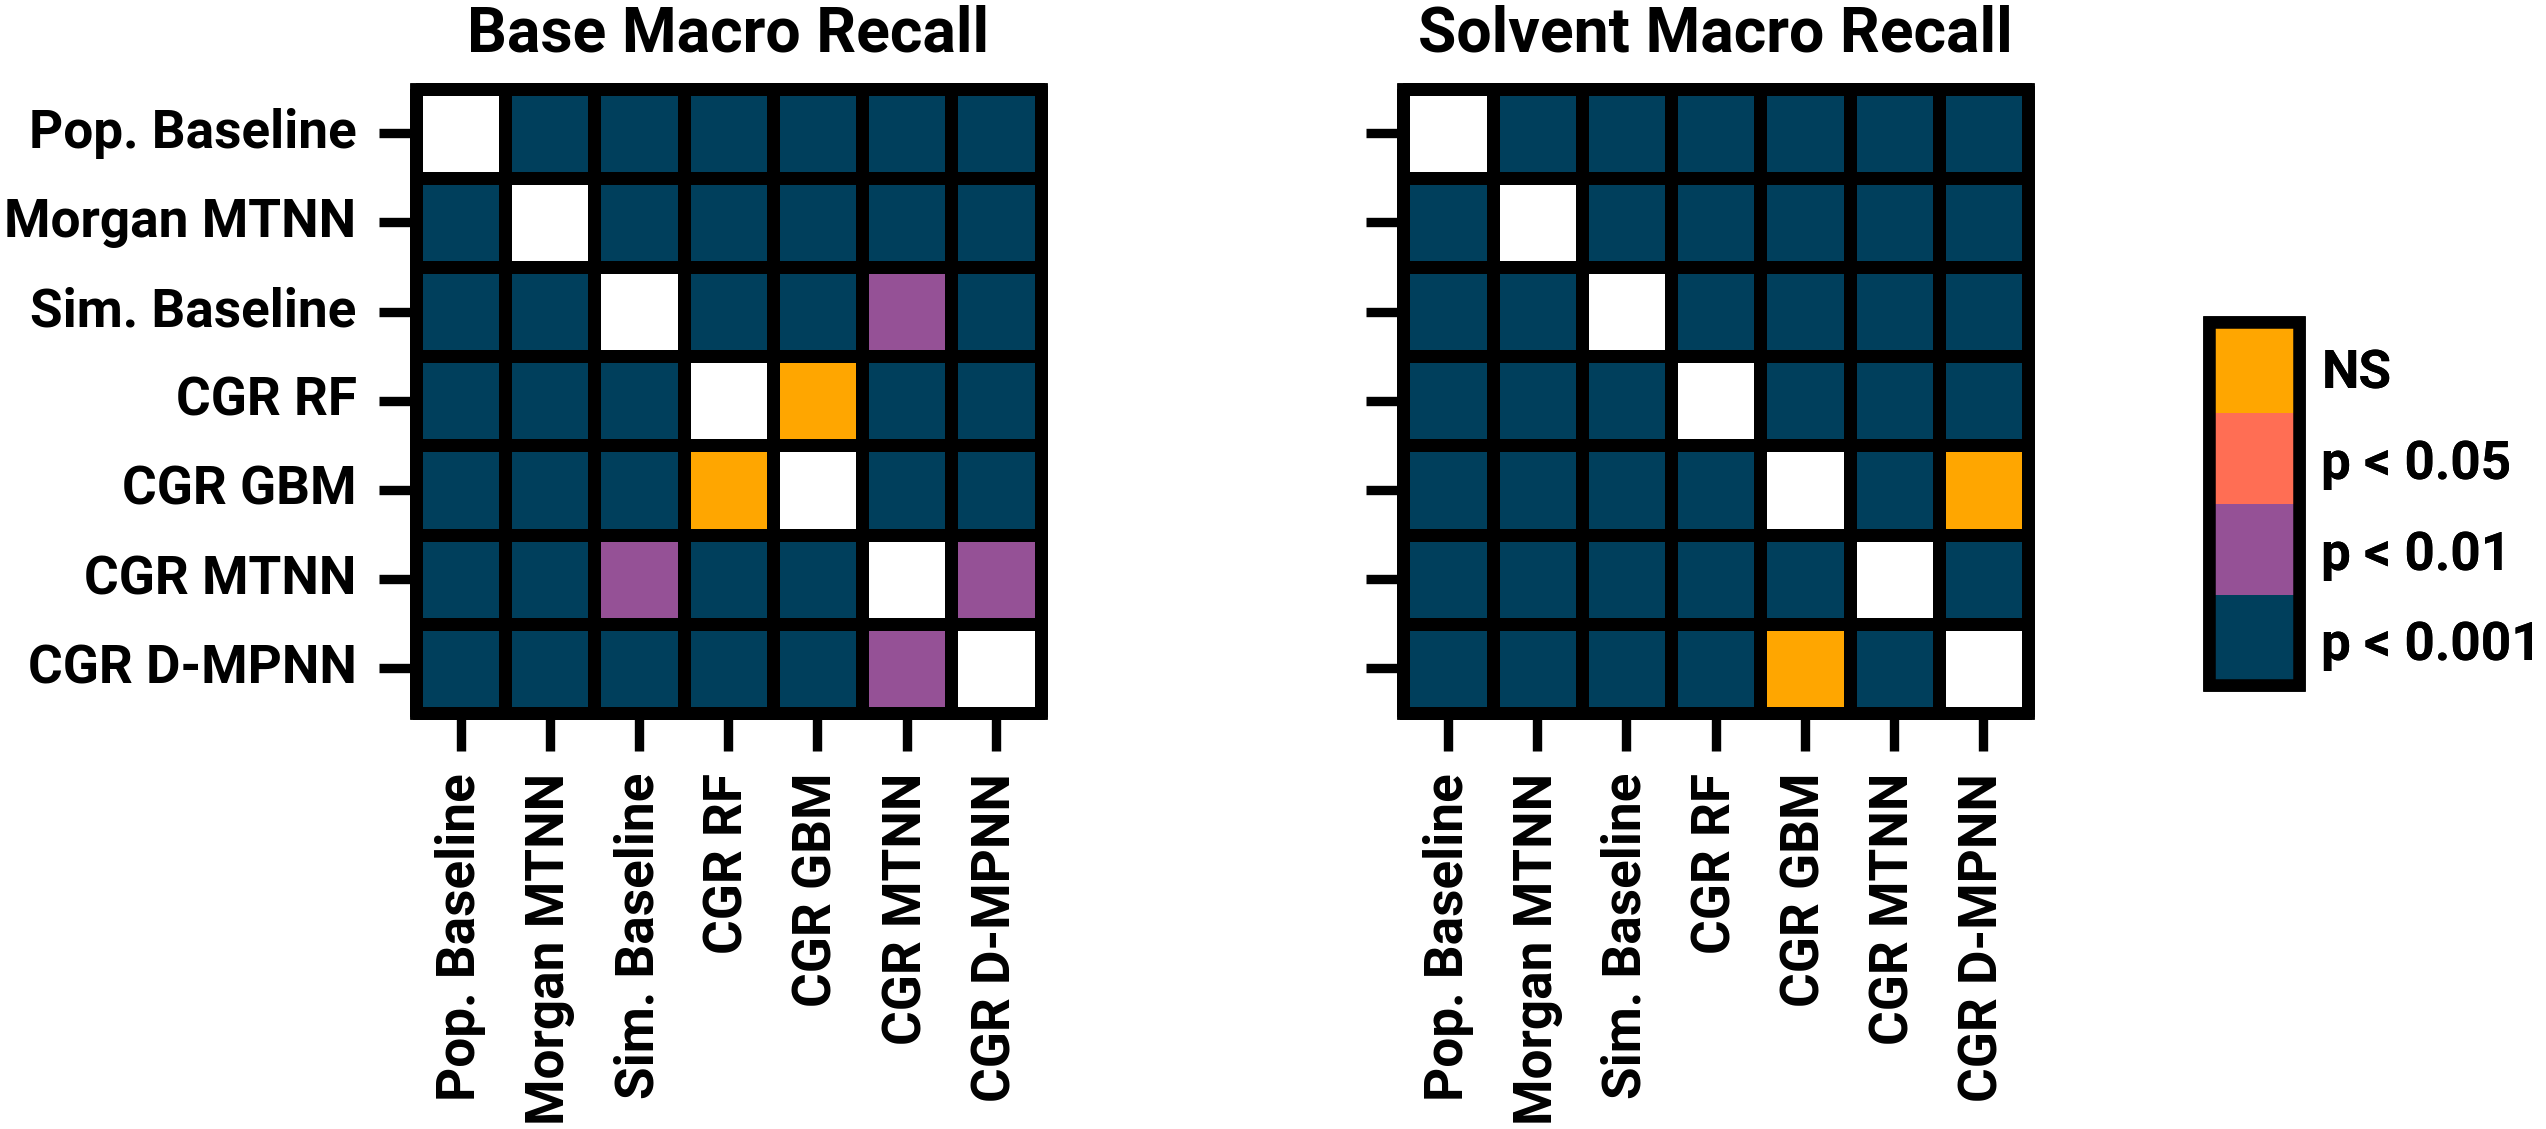

In [24]:
os.makedirs(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/metrics",
    exist_ok=True,
)

fig, axs = plt.subplots(
    ncols=len(reagent_types),
    nrows=len(metrics),
    figsize=(len(metrics) * 2.69, len(reagent_types) * 2.69),
)

custom_palette = (
    ["1"]
    + [SYNTHWAVE_PALETTE[-1]]
    + [SYNTHWAVE_PALETTE[i] for i in range(0, 5, 2)]
)

for i, metric in enumerate(metrics):
    fig2, axs2 = plt.subplots(
        nrows=1,
        ncols=len(reagent_types),
        figsize=(5, 2.69),
        sharey=True,
    )
    for j, reagent_type in enumerate(reagent_types):
        metric_name = (
            f"{reagent_type.title()} {metric.replace('_', ' ').title()}"
        )

        temp_df = combined_metrics_df.filter(
            (pl.col("reagent_type") == reagent_type)
            & (pl.col("metric") == metric)
        ).to_pandas()

        temp_df["cv"] = [
            (int(row["split"]) - 1) * 5 + int(row["fold"])
            for _, row in temp_df.iterrows()
        ]

        pivot_temp_df = temp_df.pivot(
            index="cv", columns="method", values="value"
        )

        pivot_temp_df = pivot_temp_df[
            [
                "Pop. Baseline",
                "Morgan MTNN",
                "Sim. Baseline",
                "CGR RF",
                "CGR GBM",
                "CGR MTNN",
                "CGR D-MPNN",
            ]
        ]

        pc = sp.posthoc_conover_friedman(
            pivot_temp_df,
            p_adjust="holm",
        )

        av_rank = (
            temp_df.groupby("cv")
            .value.rank(pct=True)
            .groupby(temp_df.method)
            .mean()
        )

        for k, axs_ in enumerate([axs, axs2]):
            if k == 0:
                idx = i, j
            else:
                idx = j
            axs_[idx].set_title(
                metric_name.title(),
                fontdict={"weight": "bold"},
            )

        sp_ax, sp_cb = sp.sign_plot(
            pc,
            ax=axs2[j],
            cmap=custom_palette,
            **{
                "linewidths": 2,
                "linecolor": "black",
                "clip_on": False,
                "square": True,
                "cbar_ax_bbox": [1, 0.4, 0.04, 0.3],
            },
        )

        sp.critical_difference_diagram(
            ranks=av_rank, sig_matrix=pc, ax=axs[i, j]
        )

        for spine in sp_ax.spines.values():
            spine.set_visible(True)
            spine.set_linewidth(2)

        sp_cb.outline.set_color("black")
        sp_cb.outline.set_linewidth(2)

        sp_ax.tick_params(axis="both", which="both", direction="out")
        sp_ax.tick_params(axis="both", which="minor", length=0)

    fig2.savefig(
        f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/metrics/{metric}_sp.svg",
        bbox_inches="tight",
    )

fig.savefig(
    f"../reports/figures/{SOLVENT_CLASSIFICATION}_solvs/stat_analysis/metrics/cd.svg",
    bbox_inches="tight",
)